## **Data Creation**

In [ ]:
!pip install pyJHTDB
import pyJHTDB
import pyJHTDB.dbinfo
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
def get_data(point_coords, time):

    """
    Get velocity and pressure at specified spatial points and a specified time in channel flow database.
    :param point_coords: Spatial coordinates of the data points of interest. Must be in single precision.
    :param time: Time of interest.
    :return: Velocity and velocity gradient arrays.
    """

    # Create library object
    lJHTDB = pyJHTDB.libJHTDB()

    # Initialize library object
    lJHTDB.initialize()

    # Get velocity
    u = lJHTDB.getData(time, point_coords,
                       sinterp='Lag4',
                       data_set='channel',
                       getFunction='getVelocity')

    # Get velocity gradient
    p = lJHTDB.getData(time, point_coords,
                            sinterp='Lag4',
                            data_set='channel',
                            getFunction='getPressure')

    # Finalize library object
    lJHTDB.finalize()

    return u, p

For step sizes:
for each direction:
$Num, of, Points = [(range,end - range,start) / spacing] + 1$
Here: spacing = 0.001

In [ ]:
'''#x_range
xr1 = 12.47
xr2 = 12.66
#y_range
yr1 = -1
yr2 = -0.0031
#z_range
zr1 = 4.61
zr2 = 4.82'''

#x_range
xr1 = 12.25
xr2 = 12.75
#y_range
yr1 = -1.0
yr2 = -0.5
#z_range
zr1 = 4.5
zr2 = 5.0

x_NOP = (xr2 - xr1) / 0.001 + 1
y_NOP = (yr2 - yr1) / 0.001 + 1
z_NOP = (zr2 - zr1) / 0.001 + 1
# rounding up
x_NOP = int(np.ceil(x_NOP))
y_NOP = int(np.ceil(y_NOP))
z_NOP = int(np.ceil(z_NOP))

IC

In [ ]:
# Number of time steps (temporal domain)
TD = 17

xnode = np.linspace(xr1,xr2,x_NOP)
ynode = np.linspace(yr1,yr2,y_NOP)
znode = np.linspace(zr1,zr2,z_NOP)
total_times = np.array(list(range(TD)), dtype = np.float32) * 0.0065

points = np.zeros((x_NOP, y_NOP, z_NOP, 3), np.float32)

points[:, :, :, 0] = xnode[:, None, None]
points[:, :, :, 1] = ynode[None, :, None]
points[:, :, :, 2] = znode[None, None, :]

points1 = points.reshape(-1,3)
points1.shape

(125751501, 3)

In [ ]:
elapsed = 0
ini_number = 147968 # points at the initial time step
idx_ini = np.random.choice(points1.shape[0], ini_number, replace = False)
train_ini1 = points1[idx_ini, :]
train_iniv1 = np.zeros((ini_number, 3), np.float32)
train_inip1 = np.zeros((ini_number, 1), np.float32)

size = int(ini_number / 68) # 68 is like a manually adjusted batch number
# in this loop, we assign U and P to the IC points, using get-data function
for i in range(68):

    start = time.time()  # start timer

    train_iniv1[0 + size * i: size + size * i, :], train_inip1[0 + size * i: size + size * i, :] = get_data(train_ini1[0 + size * i: size + size * i, :], 0)

    if i % 10 == 0:
        print('Elapsed time %d = %.2f seconds' % (i, elapsed))
        elapsed = time.time() - start  # end timer

print(train_iniv1.shape, train_inip1.shape)


Elapsed time 0 = 0.00 seconds
Elapsed time 10 = 4.64 seconds
Elapsed time 20 = 1.85 seconds
Elapsed time 30 = 1.87 seconds
Elapsed time 40 = 1.85 seconds
Elapsed time 50 = 1.82 seconds
Elapsed time 60 = 1.81 seconds
(147968, 3) (147968, 1)


In [ ]:
# save the initial data as the npy
np.save('train_ini1.npy',train_ini1)
np.save('train_iniv1.npy',train_iniv1)
np.save('train_inip1.npy',train_inip1)

BC

In [ ]:
points2 = points1[:, :][points1[:,0] == xr1]
points3 = points1[:, :][points1[:,0] == xr2]
points4 = points1[:, :][points1[:,1] == yr1]
points5 = points1[:, :][points1[:,1] == yr2]
points6 = points1[:, :][points1[:,2] == zr1]
points7 = points1[:, :][points1[:,2] == zr2]
print(points2.shape, points3.shape, points4.shape, points5.shape, points6.shape, points7.shape)

train_b1 = np.concatenate([points2, points3, points4, points5, points6, points7],0)
train_b1.shape

(251001, 3) (251001, 3) (251001, 3) (251001, 3) (251001, 3) (251001, 3)


(1506006, 3)

In [ ]:
# 26048 points on the boundary
b_num = 26048
idxb = np.random.choice(train_b1.shape[0], b_num, replace=False)
train_b2 = train_b1[idxb,:]
train_b2.shape

(26048, 3)

In [ ]:
train_xb1 = np.zeros((b_num*TD, 4), np.float32)
train_vb1 = np.zeros((b_num*TD, 3), np.float32)
train_pb1 = np.zeros((b_num*TD, 1), np.float32)

In [ ]:
frames = np.arange(TD)
size = int(b_num / 8) # 8 is like a manually adjusted batch number
# Get data
for frame in frames:
    start = time.time()  # start timer
    t = total_times[frame]
    print('t = %s' % t)
    for i in range(8):
        train_vb1[b_num*frame + size*i: size+b_num*frame+size*i, :], train_pb1[b_num*frame + size*i: size+b_num*frame+size*i, :] = get_data(train_b2[size*i: size+size*i, :], t)
    train_xb1[b_num*frame: b_num+b_num*frame, 0:3] = train_b2
    train_xb1[b_num*frame: b_num+b_num*frame, 3] = t

t = 0.0
t = 0.0065
t = 0.013
t = 0.0195
t = 0.026
t = 0.0325
t = 0.039
t = 0.045500003
t = 0.052
t = 0.0585
t = 0.065
t = 0.0715
t = 0.078
t = 0.0845
t = 0.091000006
t = 0.097500004
t = 0.104


In [ ]:
print(train_vb1.shape,train_pb1.shape,train_xb1.shape)
np.save('train_xb1.npy',train_xb1)
np.save('train_vb1.npy',train_vb1)
np.save('train_pb1.npy',train_pb1)

(442816, 3) (442816, 1) (442816, 4)


Data Structuring

In [ ]:
x0_train = train_ini1[:,0:1]
y0_train = train_ini1[:,1:2]
z0_train = train_ini1[:,2:3]
t0_train = np.zeros(train_ini1[:,0:1].shape, np.float32)
u0_train = train_iniv1[:,0:1]
v0_train = train_iniv1[:,1:2]
w0_train = train_iniv1[:,2:3]

xb_train = train_xb1[:,0:1]
yb_train = train_xb1[:,1:2]
zb_train = train_xb1[:,2:3]
tb_train = train_xb1[:,3:4]
ub_train = train_vb1[:,0:1]
vb_train = train_vb1[:,1:2]
wb_train = train_vb1[:,2:3]

x_train1 = xnode.reshape(-1,1)[np.random.choice(x_NOP, 40000, replace=True),:] # number of collocation points inside the domain
y_train1 = ynode.reshape(-1,1)[np.random.choice(y_NOP, 40000, replace=True),:]
z_train1 = znode.reshape(-1,1)[np.random.choice(z_NOP, 40000, replace=True),:]
x_train = np.tile(x_train1,(TD, 1))
y_train = np.tile(y_train1,(TD, 1))
z_train = np.tile(z_train1,(TD, 1))

total_times1 = np.array(list(range(TD))) * 0.0065
t_train1 = total_times1.repeat(40000)
t_train = t_train1.reshape(-1,1)

In [ ]:
print(x0_train.shape,y0_train.shape,
      z0_train.shape,t0_train.shape,
      u0_train.shape,v0_train.shape,
      w0_train.shape,
      xb_train.shape,yb_train.shape,
      zb_train.shape,tb_train.shape,
      ub_train.shape,vb_train.shape,
      wb_train.shape,
      x_train.shape, y_train.shape,
      z_train.shape, t_train.shape)

(147968, 1) (147968, 1) (147968, 1) (147968, 1) (147968, 1) (147968, 1) (147968, 1) (52096, 1) (52096, 1) (52096, 1) (52096, 1) (52096, 1) (52096, 1) (52096, 1) (200000, 1) (200000, 1) (200000, 1) (200000, 1)


## **ICT = Initial Condition Transfer**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_ini1.npy to train_ini1.npy
Saving train_inip1.npy to train_inip1.npy
Saving train_iniv1.npy to train_iniv1.npy
Saving train_pb1.npy to train_pb1.npy
Saving train_vb1.npy to train_vb1.npy
Saving train_xb1.npy to train_xb1.npy


In [ ]:
# Load Data
import numpy as np
import tensorflow as tf
import time
train_ini1 = np.load('train_ini1.npy')
train_iniv1 = np.load('train_iniv1.npy')
train_inip1 = np.load('train_inip1.npy')
train_xb1 = np.load('train_xb1.npy')
train_vb1 = np.load('train_vb1.npy')
train_pb1 = np.load('train_pb1.npy')

In [ ]:
# General Control Panel
#Test time snaps
Test_snap1 = 0
Test_snap2 = 4
Test_snap3 = 8
Test_snap4 = 12



# Epoches
Epo1 = 300
Epo2 = 400
Epo3 = 400
Epo4 = 150
Epo5 = 50
nIter = 150

In [ ]:
!pip install pyJHTDB

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.0/387.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyJHTDB: filename=pyJHTDB-20200909.0-cp310-cp310-linux_x86_64.whl size=1104195 sha256=7dcad65f7f0e057e08a01c96b0d0ad6138b7132340864f886a8c6f72d1c5f6a4
  Stored in directory: /root/.cache/pip/wheels/40/5a/24/1f1d349c6c1f17b50c7c83faa3ea8aa77e6c25409f77756a3b
Successfully built pyJHTDB


## **Regular PINN**

In [ ]:
#@title Control Panel
import tensorflow as tf
import numpy as np
import time
#Re = tf.constant(999.35, dtype=tf.float32)  # You need to ensure that Re is accessible within the scope of the TF function,
                                            # so you should either pass it as an argument to the TF.function (net_f_NS)
                                            # or make it a global constant that is accessible within the function.
# Penalization of loss terms
alpha = 20 # IC
beta = 40  # BC
# Network Architectures
layers = [4, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 4]

time_steps = 16 # number of time steps, total = 129 for training data set 1

In [ ]:
#@title Data Structuring
#x_range
xr1 = 12.25
xr2 = 12.75
#y_range
yr1 = -1.0
yr2 = -0.5
#z_range
zr1 = 4.5
zr2 = 5.0

x_NOP = (xr2 - xr1) / 0.001 + 1
y_NOP = (yr2 - yr1) / 0.001 + 1
z_NOP = (zr2 - zr1) / 0.001 + 1
# rounding up
x_NOP = int(np.ceil(x_NOP))
y_NOP = int(np.ceil(y_NOP))
z_NOP = int(np.ceil(z_NOP))

b_num = 26048 # number of BC points at each time frame
n_t = time_steps * (b_num + 1)

x0_train = train_ini1[:, 0:1]
y0_train = train_ini1[:, 1:2]
z0_train = train_ini1[:, 2:3]
t0_train = np.zeros(train_ini1[:, 0:1].shape, dtype= np.float32)
u0_train = train_iniv1[:, 0:1]
v0_train = train_iniv1[:, 1:2]
w0_train = train_iniv1[:, 2:3]

xb_train = train_xb1[:n_t, 0:1]
yb_train = train_xb1[:n_t, 1:2]
zb_train = train_xb1[:n_t, 2:3]
tb_train = train_xb1[:n_t, 3:4]
ub_train = train_vb1[:n_t, 0:1]
vb_train = train_vb1[:n_t, 1:2]
wb_train = train_vb1[:n_t, 2:3]

xnode = np.linspace(xr1, xr2, x_NOP)
ynode = np.linspace(yr1, yr2, y_NOP)
znode = np.linspace(zr1, zr2, z_NOP)

#total_times = np.array(list(range(4000)), dtype=np.float32) * 0.0065

x_train1 = xnode.reshape(-1, 1)[np.random.choice(x_NOP, 40000, replace=True), :] # number of collocation points = second number in parantheses
y_train1 = ynode.reshape(-1, 1)[np.random.choice(y_NOP, 40000, replace=True), :]
z_train1 = znode.reshape(-1, 1)[np.random.choice(z_NOP, 40000, replace=True), :]
x_train = np.tile(x_train1, (time_steps, 1)).astype(np.float32)
y_train = np.tile(y_train1, (time_steps, 1)).astype(np.float32)
z_train = np.tile(z_train1, (time_steps, 1)).astype(np.float32)

total_times1 = np.array(list(range(time_steps))) * 0.0065
t_train1 = total_times1.repeat(40000)
t_train = t_train1.reshape(-1, 1).astype(np.float32)

X0 = np.concatenate([x0_train, y0_train, z0_train, t0_train], 1)  # remove the second bracket
Xb = np.concatenate([xb_train, yb_train, zb_train, tb_train], 1)
X = np.concatenate([x_train, y_train, z_train, t_train], 1)

x0 = X0[:, 0:1]
y0 = X0[:, 1:2]
z0 = X0[:, 2:3]
t0 = X0[:, 3:4]
u0 = u0_train
v0 = v0_train
w0 = w0_train

xb = Xb[:, 0:1]
yb = Xb[:, 1:2]
zb = Xb[:, 2:3]
tb = Xb[:, 3:4]
ub = ub_train
vb = vb_train
wb = wb_train

x = X[:, 0:1]
y = X[:, 1:2]
z = X[:, 2:3]
t = X[:, 3:4]

In [ ]:
#@title Neural Nets
lowb = Xb.min(0)  # minimal number in each column
upb = Xb.max(0)
#lowb = tf.cast(lowb, dtype=tf.float32)
#upb = tf.cast(upb, dtype=tf.float32)

def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
    return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                        dtype=tf.float32)

# do not need adaptation
def initialize_NN(layers):
    weights = []
    biases = []
    num_layers = len(layers)
    for l in range(0, num_layers - 1):
        W = xavier_init(size=[layers[l], layers[l + 1]])
        b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)
    return weights, biases

weights, biases = initialize_NN(layers)

# do not need adaptation


# do not need adaptation
def forward_pass(X, weights, biases):
    num_layers = len(weights) + 1

    H = 2.0 * (tf.cast(X, dtype=tf.float32) - lowb) / (upb - lowb) - 1.0
    for l in range(0, num_layers - 2):
        W = weights[l]
        b = biases[l]
        H = tf.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

In [ ]:
#@title Computation Graph, Loss Function and Gradient
def net_f_NS(x, y, z, t):
    Re = 999.35
  # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as gg:
      gg.watch(t)
      gg.watch(x)
      gg.watch(y)
      gg.watch(z)
      with tf.GradientTape(persistent=True) as g:
          g.watch(t)
          g.watch(x)
          g.watch(y)
          g.watch(z)
          u_v_w_p = forward_pass(tf.concat([x, y, z, t], 1), weights, biases)
          u = u_v_w_p[:, 0:1]
          v = u_v_w_p[:, 1:2]
          w = u_v_w_p[:, 2:3]
          p = u_v_w_p[:, 3:4]
      u_t = tf.gradients(u, t)[0]
      u_x = tf.gradients(u, x)[0]
      u_y = tf.gradients(u, y)[0]
      u_z = tf.gradients(u, z)[0]

      v_t = tf.gradients(v, t)[0]
      v_x = tf.gradients(v, x)[0]
      v_y = tf.gradients(v, y)[0]
      v_z = tf.gradients(v, z)[0]

      w_t = tf.gradients(w, t)[0]
      w_x = tf.gradients(w, x)[0]
      w_y = tf.gradients(w, y)[0]
      w_z = tf.gradients(w, z)[0]

      p_x = tf.gradients(p, x)[0]
      p_y = tf.gradients(p, y)[0]
      p_z = tf.gradients(p, z)[0]

      del g
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    u_zz = tf.gradients(u_z, z)[0]

    v_xx = tf.gradients(v_x, x)[0]
    v_yy = tf.gradients(v_y, y)[0]
    v_zz = tf.gradients(v_z, z)[0]

    w_xx = tf.gradients(w_x, x)[0]
    w_yy = tf.gradients(w_y, y)[0]
    w_zz = tf.gradients(w_z, z)[0]
    del gg

    f_u = u_t + (u * u_x + v * u_y + w * u_z) + p_x - 1 / Re * (u_xx + u_yy + u_zz)
    f_v = v_t + (u * v_x + v * v_y + w * v_z) + p_y - 1 / Re * (v_xx + v_yy + v_zz)
    f_w = w_t + (u * w_x + v * w_y + w * w_z) + p_z - 1 / Re * (w_xx + w_yy + w_zz)
    f_e = u_x + v_y + w_z

    return u, v, w, p, f_u, f_v, f_w, f_e

# Forward pass
def net_NS(x, y, z, t):
  u_v_w_p = forward_pass(tf.concat([x, y, z, t], 1), weights, biases)
  u = u_v_w_p[:, 0:1]
  v = u_v_w_p[:, 1:2]
  w = u_v_w_p[:, 2:3]
  p = u_v_w_p[:, 3:4]

  return u, v, w, p

def compute_loss(xei, yei, zei, tei, uei, vei, wei, xeb, yeb, zeb, teb, ueb, veb, web, xee, yee, zee, tee):
  u_ini_pred, v_ini_pred, w_ini_pred, p_ini_pred = net_NS(xei, yei, zei, tei)
  u_boundary_pred, v_boundary_pred, w_boundary_pred, p_boundary_pred = net_NS(xeb, yeb, zeb, teb)
  _, _, _, _, f_u_pred, f_v_pred, f_w_pred, f_e_pred = net_f_NS(xee, yee, zee, tee)

  loss_i = tf.reduce_sum(tf.square(uei - u_ini_pred)) + \
                    tf.reduce_sum(tf.square(vei - v_ini_pred)) + \
                    tf.reduce_sum(tf.square(wei - w_ini_pred))
  loss_b = tf.reduce_sum(tf.square(ueb - u_boundary_pred)) + \
                    tf.reduce_sum(tf.square(veb - v_boundary_pred)) + \
                    tf.reduce_sum(tf.square(web - w_boundary_pred))
  loss_pde = tf.reduce_sum(tf.square(f_u_pred)) + \
                    tf.reduce_sum(tf.square(f_v_pred)) + \
                    tf.reduce_sum(tf.square(f_w_pred)) + \
                    tf.reduce_sum(tf.square(f_e_pred))

  loss = alpha * loss_i + beta * loss_b + loss_pde

  return loss, loss_i, loss_b, loss_pde

def get_grad(xei, yei, zei, tei, uei, vei, wei, xeb, yeb, zeb, teb, ueb, veb, web, xee, yee, zee, tee):
  with tf.GradientTape(persistent=True) as tape:
    # This tape is for derivatives with respect to trainable variables of NN (weights & biases)
    tape.watch([weights, biases])
    loss, loss_i, loss_b, loss_pde = compute_loss(xei, yei, zei, tei, uei, vei, wei, xeb, yeb, zeb, teb, ueb, veb, web, xee, yee, zee, tee)
  g = tape.gradient(loss, weights+biases)
  del tape
  return loss, g, loss_i, loss_b, loss_pde

In [ ]:
#@title Run (Exp)
'''
from time import time
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(xei, yei, zei, tei, uei, vei, wei, xeb, yeb, zeb, teb, ueb, veb, web, xee, yee, zee, tee, lr):
  # Compute current loss and gradient w.r.t. parameters
  loss, grad, loss_i, loss_b, loss_pde = get_grad(xei, yei, zei, tei, uei, vei, wei, xeb, yeb, zeb, teb, ueb, veb, web, xee, yee, zee, tee)
  #Do GD step
  optim.lr.assign(lr)  # Assign new learning rate
  optim.apply_gradients(zip(grad, weights+biases))

  return loss, loss_i, loss_b, loss_pde

# Define the learning rate schedule based on epochs
initial_learning_rate = 1e-3
decay_epochs = 25  # Adjust this value as needed
decay_rate = 0.70   # Adjust this value as needed

# List to record learning rates
learning_rates = []

def learning_rate_schedule(epoch):
    current_lr = initial_learning_rate * (decay_rate ** (epoch // decay_epochs))
    learning_rates.append(current_lr)  # Record the current learning rate
    return current_lr

# Create the optimizer with the learning rate schedule
optim = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

def run(epoch, nIter):
  hist1 = []
  hist2 = []
  hist3 = []
  hist4 = []

  for ep in range(epoch):

    # Adjust the learning rate based on the current epoch
    current_lr = learning_rate_schedule(ep)
    optim.lr.assign(current_lr)

    batch_size1 = len(x0) // nIter
    batch_size2 = len(xb) // nIter
    batch_size3 = len(x) // nIter

    arr1 = np.arange(batch_size1 * nIter)
    arr2 = np.arange(batch_size2 * nIter)
    arr3 = np.arange(batch_size3 * nIter)

    permu1 = np.random.permutation(arr1).reshape((nIter, batch_size1))
    permu2 = np.random.permutation(arr2).reshape((nIter, batch_size2))
    permu3 = np.random.permutation(arr3).reshape((nIter, batch_size3))

    for it in range (nIter):
      x02 = x0[permu1[it, :], :]
      y02 = y0[permu1[it, :], :]
      z02 = z0[permu1[it, :], :]
      t02 = t0[permu1[it, :], :]
      u02 = u0[permu1[it, :], :]
      v02 = v0[permu1[it, :], :]
      w02 = w0[permu1[it, :], :]
      xb2 = xb[permu2[it, :], :]
      yb2 = yb[permu2[it, :], :]
      zb2 = zb[permu2[it, :], :]
      tb2 = tb[permu2[it, :], :]
      ub2 = ub[permu2[it, :], :]
      vb2 = vb[permu2[it, :], :]
      wb2 = wb[permu2[it, :], :]
      x2 = x[permu3[it, :], :]
      y2 = y[permu3[it, :], :]
      z2 = z[permu3[it, :], :]
      t2 = t[permu3[it, :], :]

      loss, loss_i, loss_b, loss_pde  = train_step(x02, y02, z02, t02, u02, v02, w02, xb2, yb2, zb2, tb2, ub2, vb2, wb2, x2, y2, z2, t2, current_lr)
      #Append current loss to the hist
      hist1.append(loss.numpy())
      hist2.append(loss_i.numpy())
      hist3.append(loss_b.numpy())
      hist4.append(loss_pde.numpy())

      if it%50 == 0:
        print('ep {:03d}, It {:05d}, loss = {:10.4e}, loss_i = {:10.4e}, loss_b = {:10.4e}, loss_pde = {:10.4e}' .format(ep, it,loss, loss_i, loss_b, loss_pde))
  return hist1, hist2, hist3, hist4
#start timer

time0 = time()
loss, loss_i, loss_b, loss_pde = run(400, 150)

# Print computation time
print('\nComputation time: {} seconds' .format(time()-time0))'''

"\nfrom time import time\n# Define one training step as a TensorFlow function to increase speed of training\n@tf.function\ndef train_step(xei, yei, zei, tei, uei, vei, wei, xeb, yeb, zeb, teb, ueb, veb, web, xee, yee, zee, tee, lr):\n  # Compute current loss and gradient w.r.t. parameters\n  loss, grad, loss_i, loss_b, loss_pde = get_grad(xei, yei, zei, tei, uei, vei, wei, xeb, yeb, zeb, teb, ueb, veb, web, xee, yee, zee, tee)\n  #Do GD step\n  optim.lr.assign(lr)  # Assign new learning rate\n  optim.apply_gradients(zip(grad, weights+biases))\n\n  return loss, loss_i, loss_b, loss_pde\n\n# Define the learning rate schedule based on epochs\ninitial_learning_rate = 1e-3\ndecay_epochs = 25  # Adjust this value as needed\ndecay_rate = 0.70   # Adjust this value as needed\n\n# List to record learning rates\nlearning_rates = []\n\ndef learning_rate_schedule(epoch):\n    current_lr = initial_learning_rate * (decay_rate ** (epoch // decay_epochs))\n    learning_rates.append(current_lr)  # Reco

In [ ]:
#@title Run (manual)
from time import time
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(xei, yei, zei, tei, uei, vei, wei, xeb, yeb, zeb, teb, ueb, veb, web, xee, yee, zee, tee, lr):
  # Compute current loss and gradient w.r.t. parameters
  loss, grad, loss_i, loss_b, loss_pdf = get_grad(xei, yei, zei, tei, uei, vei, wei, xeb, yeb, zeb, teb, ueb, veb, web, xee, yee, zee, tee)
  #Do GD step
  optim.lr.assign(lr)  # Assign new learning rate
  optim.apply_gradients(zip(grad, weights+biases))

  return loss, loss_i, loss_b, loss_pdf



def run(epoch, nIter, lr):
  hist1 = []
  hist2 = []
  hist3 = []
  hist4 = []

  for ep in range(epoch):

    batch_size1 = len(x0) // nIter
    batch_size2 = len(xb) // nIter
    batch_size3 = len(x) // nIter

    arr1 = np.arange(batch_size1 * nIter)
    arr2 = np.arange(batch_size2 * nIter)
    arr3 = np.arange(batch_size3 * nIter)

    permu1 = np.random.permutation(arr1).reshape((nIter, batch_size1))
    permu2 = np.random.permutation(arr2).reshape((nIter, batch_size2))
    permu3 = np.random.permutation(arr3).reshape((nIter, batch_size3))

    for it in range (nIter):
      x02 = x0[permu1[it, :], :]
      y02 = y0[permu1[it, :], :]
      z02 = z0[permu1[it, :], :]
      t02 = t0[permu1[it, :], :]
      u02 = u0[permu1[it, :], :]
      v02 = v0[permu1[it, :], :]
      w02 = w0[permu1[it, :], :]
      xb2 = xb[permu2[it, :], :]
      yb2 = yb[permu2[it, :], :]
      zb2 = zb[permu2[it, :], :]
      tb2 = tb[permu2[it, :], :]
      ub2 = ub[permu2[it, :], :]
      vb2 = vb[permu2[it, :], :]
      wb2 = wb[permu2[it, :], :]
      x2 = x[permu3[it, :], :]
      y2 = y[permu3[it, :], :]
      z2 = z[permu3[it, :], :]
      t2 = t[permu3[it, :], :]

      loss, loss_i, loss_b, loss_pdf  = train_step(x02, y02, z02, t02, u02, v02, w02, xb2, yb2, zb2, tb2, ub2, vb2, wb2, x2, y2, z2, t2, lr)
      #Append current loss to the hist
      hist1.append(loss.numpy())
      hist2.append(loss_i.numpy())
      hist3.append(loss_b.numpy())
      hist4.append(loss_pdf.numpy())

      if it%50 == 0:
        print('ep {:03d}, It {:05d}, loss = {:10.4e}, loss_i = {:10.4e}, loss_b = {:10.4e}, loss_pdf = {:10.4e}' .format(ep, it,loss, loss_i, loss_b, loss_pdf))
  return hist1, hist2, hist3, hist4
#start timer
# Create the optimizer with a placeholder learning rate
optim = tf.keras.optimizers.Adam(learning_rate=0.0)
time0 = time()
loss1, loss_i1, loss_b1, loss_pdf1 = run(Epo1, nIter, 1e-3)
loss2, loss_i2, loss_b2, loss_pdf2 = run(Epo2, nIter, 3e-4)
loss3, loss_i3, loss_b3, loss_pdf3 = run(Epo3, nIter, 5e-5)
loss4, loss_i4, loss_b4, loss_pdf4 = run(Epo4, nIter, 1e-5)
loss5, loss_i5, loss_b5, loss_pdf5 = run(Epo5, nIter, 1e-6)
# Print computation time
print('\nComputation time: {} seconds' .format(time()-time0))

ep 000, It 00000, loss = 9.7843e+04, loss_i = 7.6469e+02, loss_b = 1.9312e+03, loss_pdf = 5.2994e+03
ep 000, It 00050, loss = 7.0821e+03, loss_i = 3.2065e+01, loss_b = 1.5410e+02, loss_pdf = 2.7684e+02
ep 000, It 00100, loss = 5.4590e+03, loss_i = 3.0252e+01, loss_b = 1.1970e+02, loss_pdf = 6.5876e+01
ep 001, It 00000, loss = 4.3581e+03, loss_i = 2.7459e+01, loss_b = 9.3675e+01, loss_pdf = 6.1879e+01
ep 001, It 00050, loss = 3.0602e+03, loss_i = 2.2177e+01, loss_b = 6.2961e+01, loss_pdf = 9.8218e+01
ep 001, It 00100, loss = 2.6230e+03, loss_i = 1.8845e+01, loss_b = 5.3453e+01, loss_pdf = 1.0796e+02
ep 002, It 00000, loss = 2.1968e+03, loss_i = 1.6783e+01, loss_b = 4.4464e+01, loss_pdf = 8.2594e+01
ep 002, It 00050, loss = 1.8223e+03, loss_i = 1.5283e+01, loss_b = 3.6271e+01, loss_pdf = 6.5815e+01
ep 002, It 00100, loss = 1.5671e+03, loss_i = 1.4377e+01, loss_b = 3.0610e+01, loss_pdf = 5.5206e+01
ep 003, It 00000, loss = 1.4240e+03, loss_i = 1.3227e+01, loss_b = 2.7853e+01, loss_pdf = 4

In [ ]:
!pip install pyJHTDB

<ipython-input-16-86f15fcaf3ea>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.semilogy(range(len(loss_i)), loss_i,'k-', c = 'r', label = 'Loss IC')
<ipython-input-16-86f15fcaf3ea>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.semilogy(range(len(loss_b)), loss_b,'k-', c = 'b', label = 'Loss BC')
<ipython-input-16-86f15fcaf3ea>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.semilogy(range(len(loss_pdf)), loss_pdf,'k-', c = 'g', label = 'Loss pde')


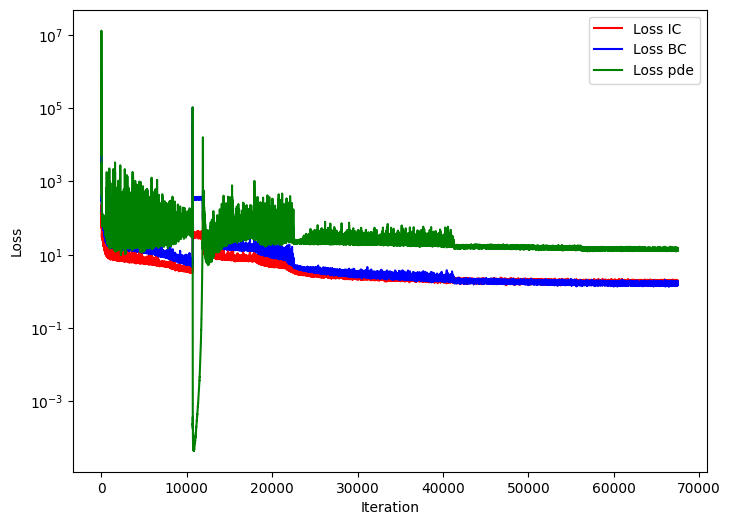

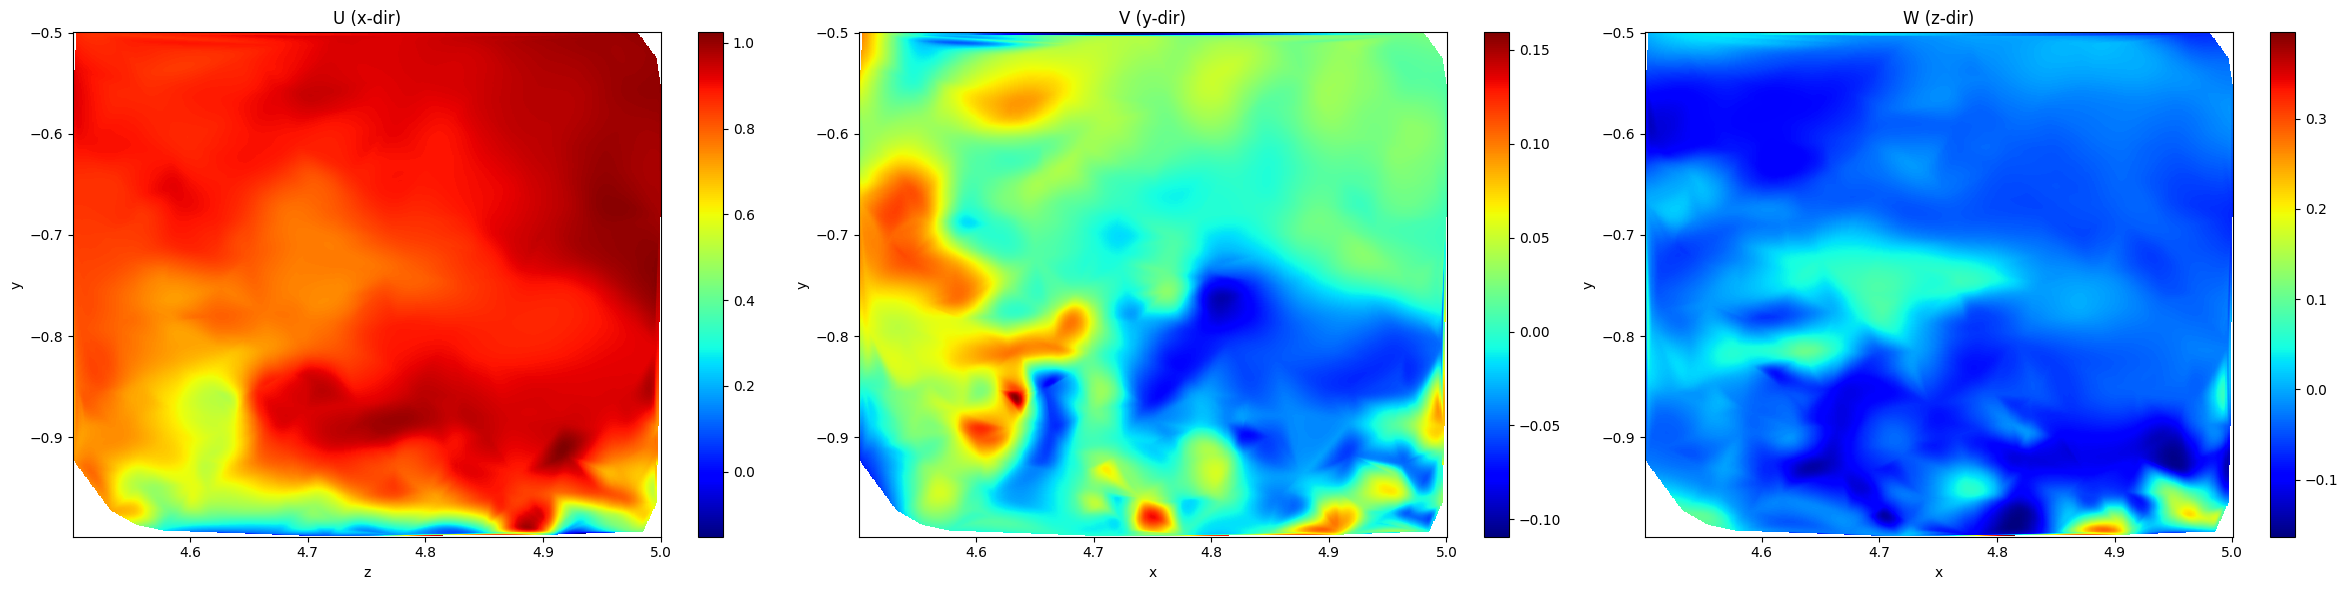

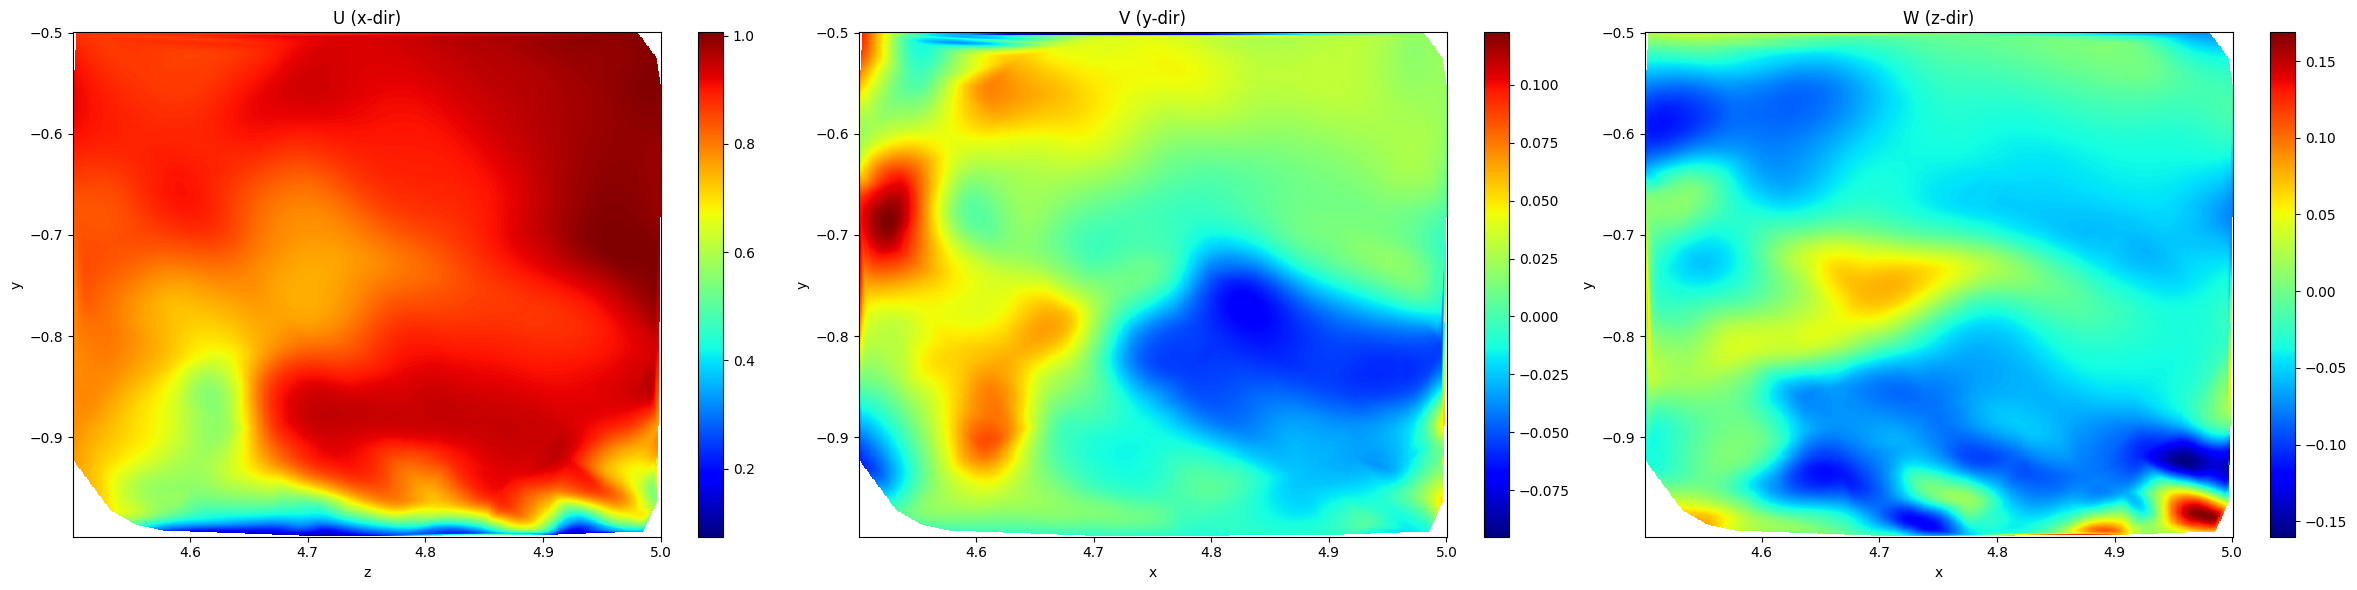

Error u: 2.905309e-02
Error v: 4.649479e-01
Error v: 3.601172e-01


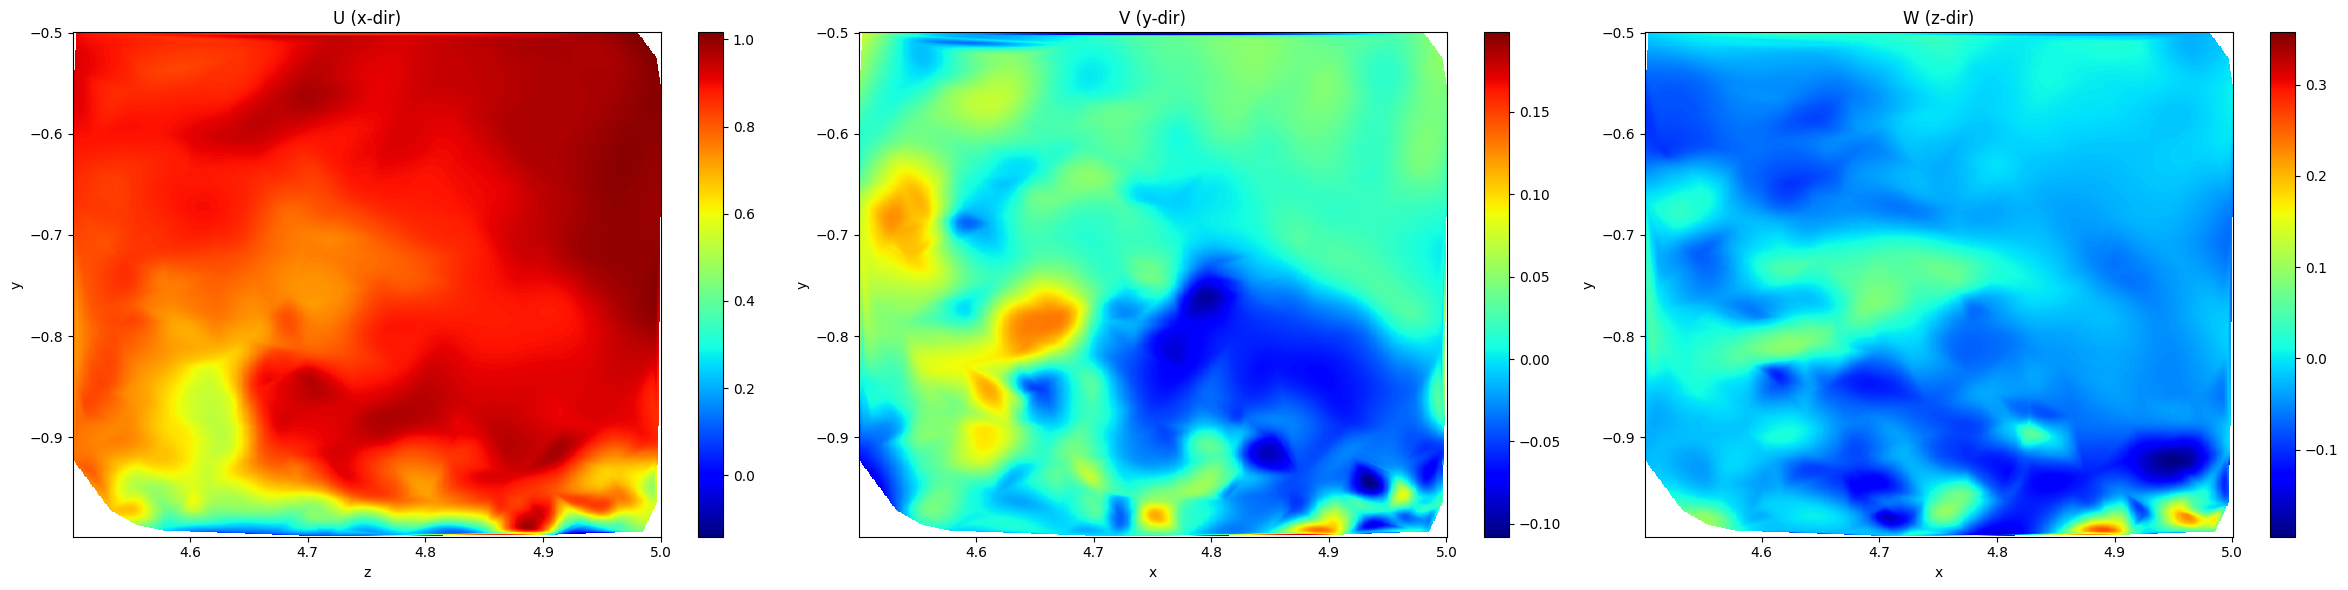

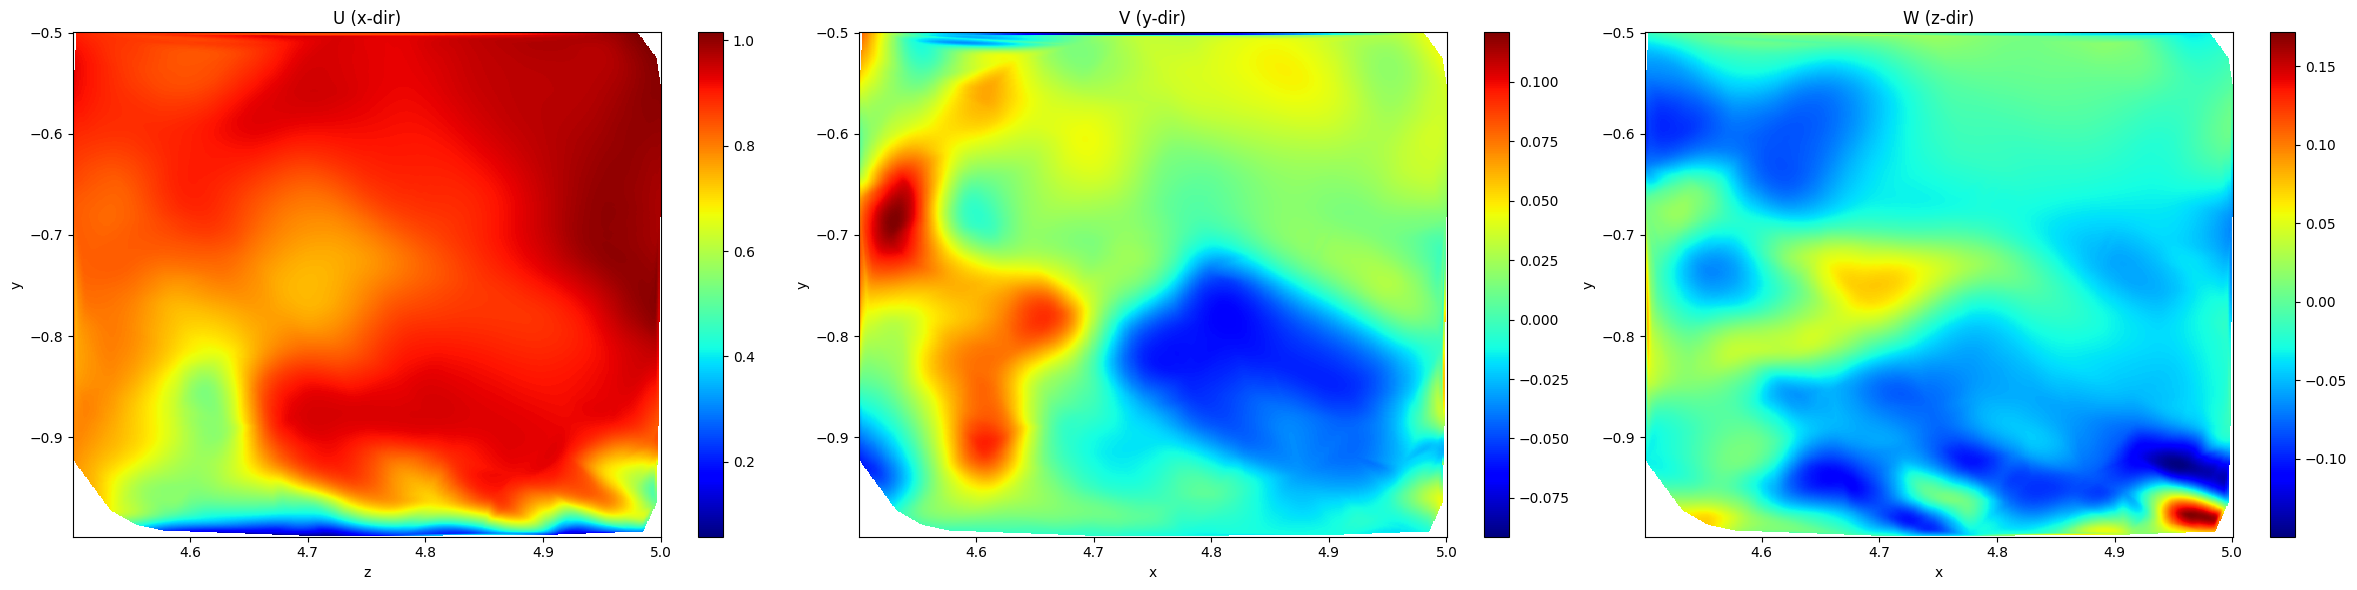

Error u: 3.113195e-02
Error v: 4.446750e-01
Error v: 3.889397e-01


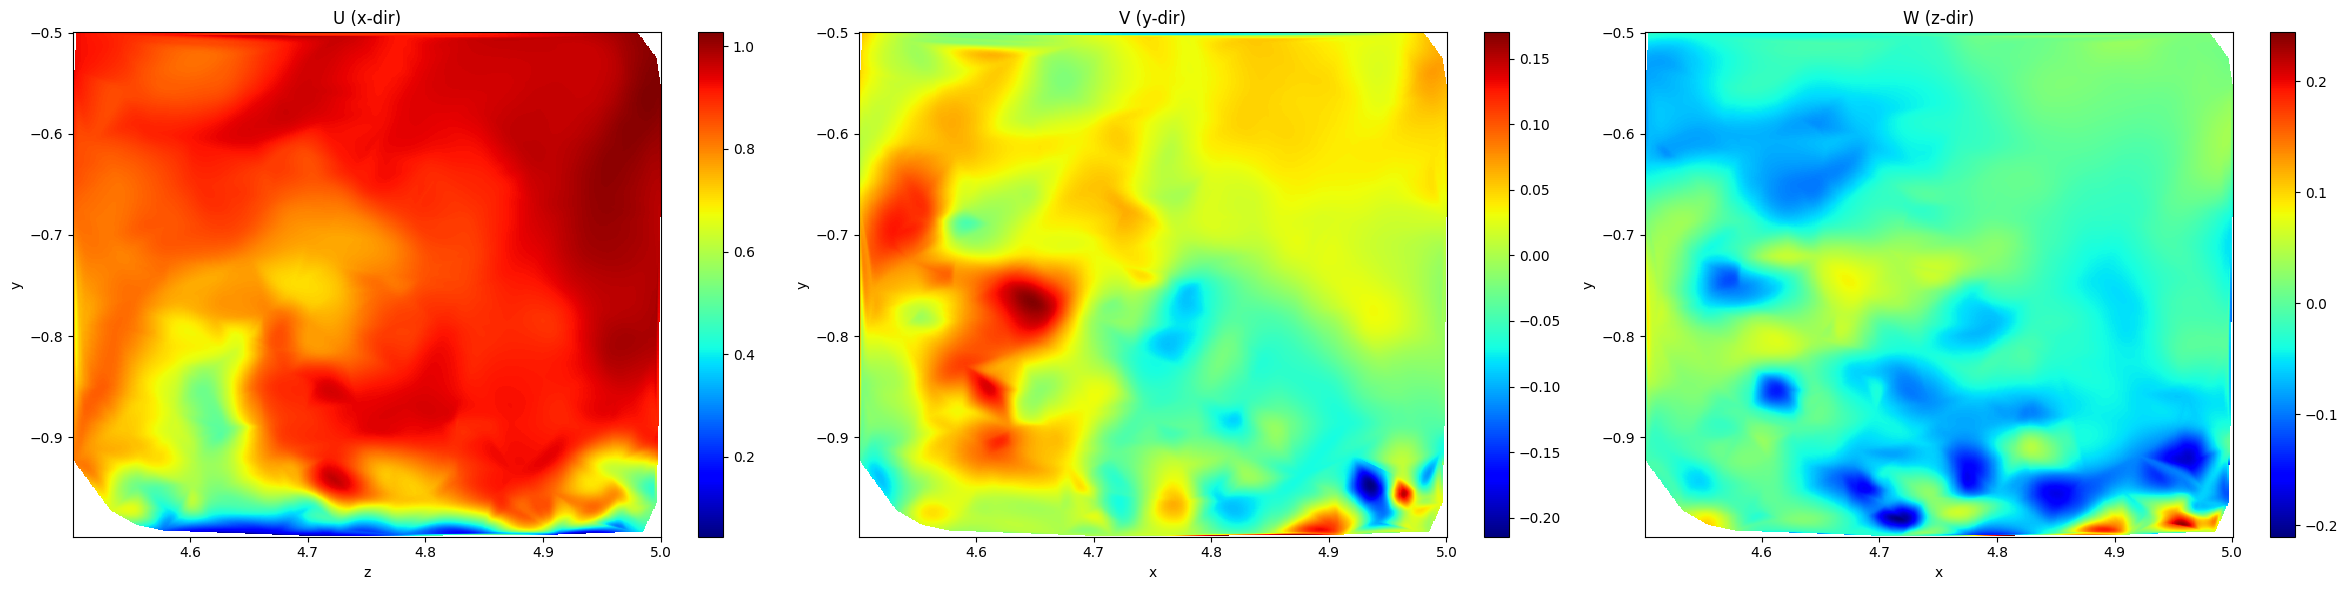

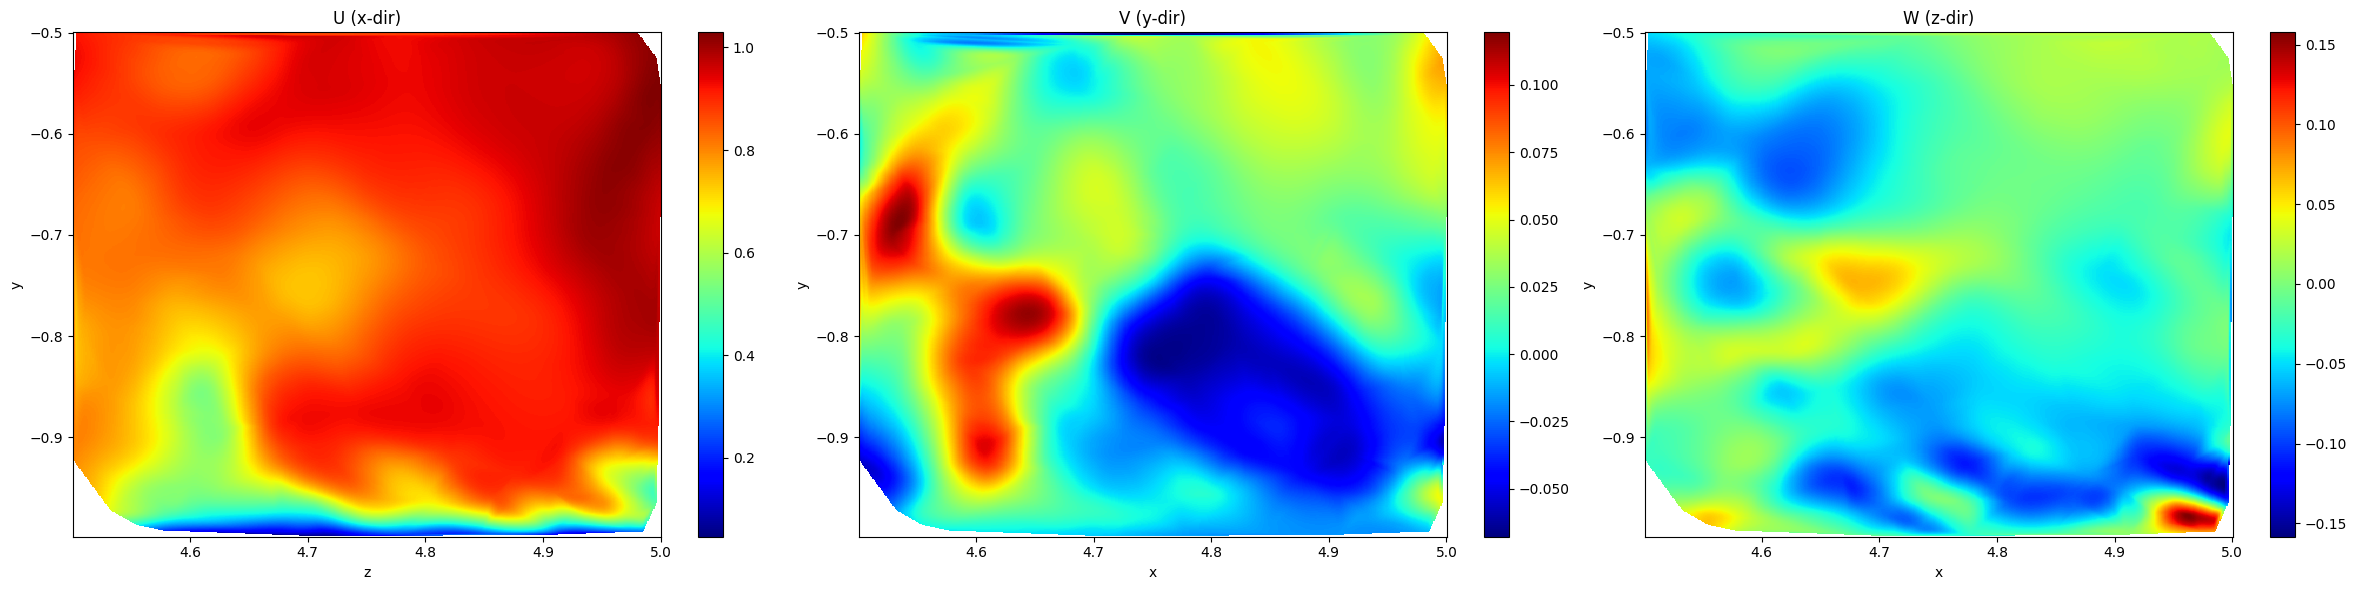

Error u: 3.614407e-02
Error v: 4.438067e-01
Error v: 4.257499e-01


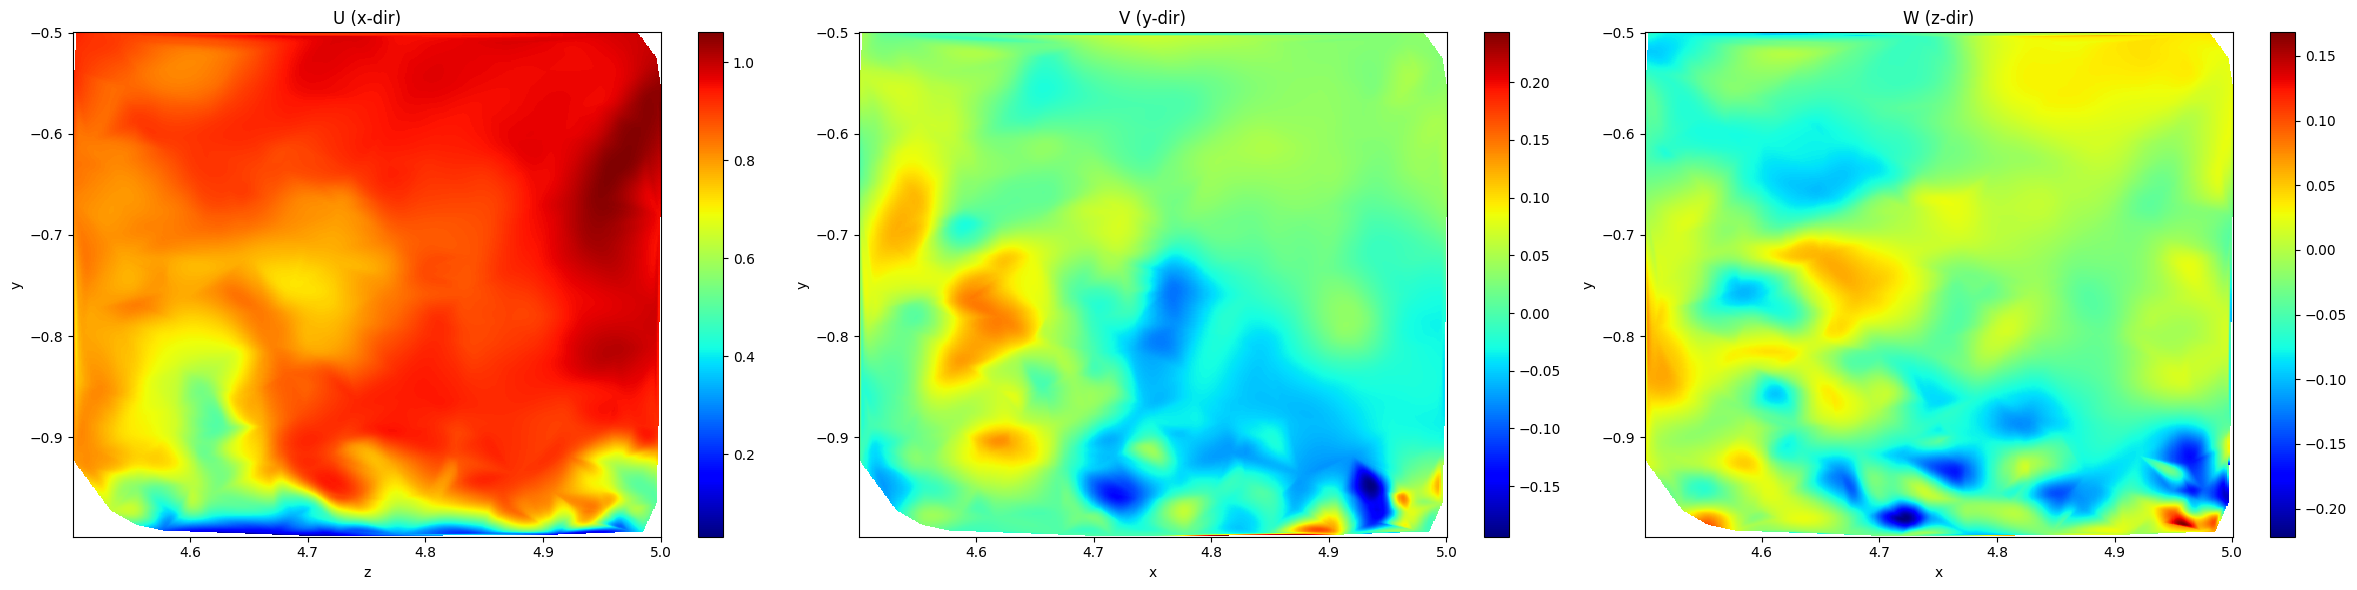

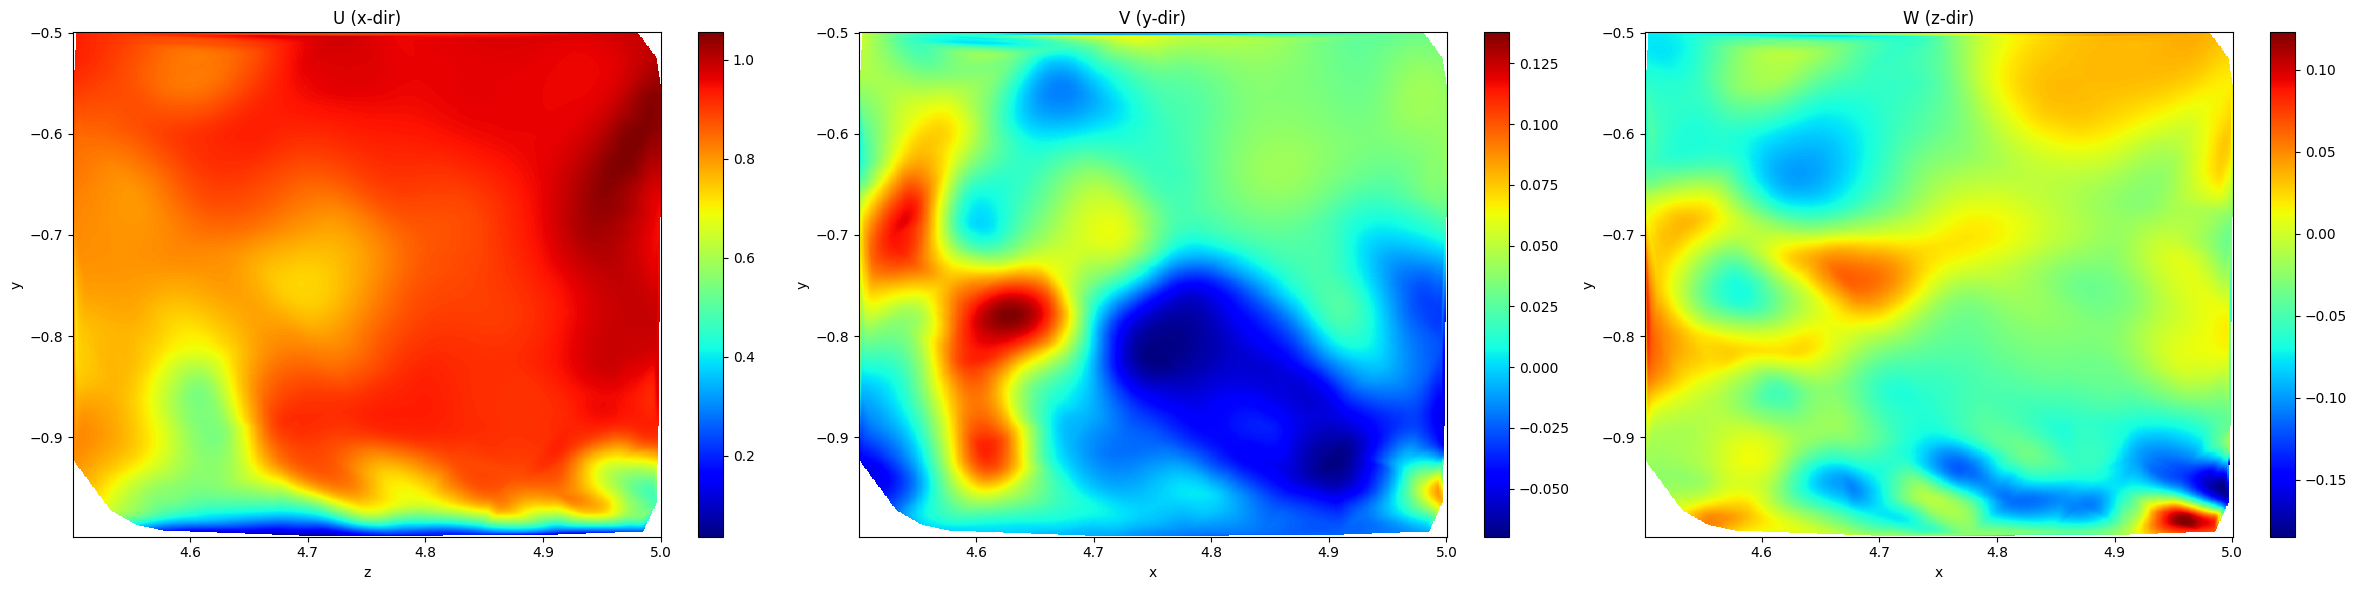

Error u: 3.470925e-02
Error v: 4.948308e-01
Error v: 4.401079e-01


In [ ]:
# @title Results
import pyJHTDB
import pyJHTDB.dbinfo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
######################################################################################################## loss decay
loss = np.concatenate((loss1, loss2, loss3, loss4, loss5), 0)
loss_i = np.concatenate((loss_i1, loss_i2, loss_i3, loss_i4, loss_i5), 0)
loss_b = np.concatenate((loss_b1, loss_b2, loss_b3, loss_b4, loss_b5), 0)
loss_pdf = np.concatenate((loss_pdf1, loss_pdf2, loss_pdf3, loss_pdf4, loss_pdf5), 0)

fig2 = plt.figure(figsize=(18,6))
ax = fig2.add_subplot(1,2,1)
ax.semilogy(range(len(loss_i)), loss_i,'k-', c = 'r', label = 'Loss IC')
ax.semilogy(range(len(loss_b)), loss_b,'k-', c = 'b', label = 'Loss BC')
ax.semilogy(range(len(loss_pdf)), loss_pdf,'k-', c = 'g', label = 'Loss pde')
#ax.semilogy(range(len(loss)), loss,'k-', c = 'c', label = 'Loss')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss');
ax.legend(loc='upper right', frameon=True)
plt.savefig('PINN-loss.png', bbox_inches='tight', dpi=600)
plt.show()
######################################################################################################## download reference data
def get_data(point_coords, time):
    """
    Get velocity and pressure at specified spatial points and a specified time in channel flow database.
    :param point_coords: Spatial coordinates of the data points of interest. Must be in single precision.
    :param time: Time of interest.
    :return: Velocity and velocity gradient arrays.
    """

    # Create library object
    lJHTDB = pyJHTDB.libJHTDB()

    # Initialize library object
    lJHTDB.initialize()

    # Get velocity
    u = lJHTDB.getData(time, point_coords,
                       sinterp='Lag4',
                       data_set='channel',
                       getFunction='getVelocity')

    # Get velocity gradient
    p = lJHTDB.getData(time, point_coords,
                            sinterp='Lag4',
                            data_set='channel',
                            getFunction='getPressure')

    # Finalize library object
    lJHTDB.finalize()

    return u, p

######################################################################################################## setting coordinates
xnode = np.linspace(xr1, xr1, 1) #to plot at a z-y plane (x=x-min)
ynode = np.linspace(yr1, yr2, y_NOP)
znode = np.linspace(zr1, zr2, z_NOP)


points = np.zeros((1, y_NOP, z_NOP, 3), np.float32) #to plot at a z-y plane (x=12.66)
points[:, :, :, 0] = xnode[:, None, None]
points[:, :, :, 1] = ynode[None, :, None]
points[:, :, :, 2] = znode[None, None, :]

points1 = points.reshape(-1,3)

idx_test = np.random.choice(points1.shape[0],500,replace = False)
test_l = points1[idx_test, :] # test points locations
######################################################################################################## results function
def results(spatio, temporal, test_snap):
  test_v , test_p = get_data(spatio, temporal)

  x_test = spatio[:,0]
  x_test = x_test.reshape(-1,1)
  y_test = spatio[:,1]
  y_test = y_test.reshape(-1,1)
  z_test = spatio[:,2]
  z_test = z_test.reshape(-1,1)

  u_star = test_v[:,0]
  u_star = u_star.reshape(-1,1)
  v_star = test_v[:,1]
  v_star = v_star.reshape(-1,1)
  w_star = test_v[:,2]
  w_star = w_star.reshape(-1,1)
  p_star = test_p

  X_s1 = np.concatenate((z_test, y_test), axis = 1)
  lbnd = X_s1.min(0)
  ubnd = X_s1.max(0)

  nn = 500 # grid size

  z = np.linspace(lbnd[0], ubnd[0], nn)
  y = np.linspace(lbnd[1], ubnd[1], nn)

  Z, Y = np.meshgrid(z, y)
  #X_star = np.concatenate((x_test, y_test, z_test), axis = 1)
  U_ref = griddata(X_s1, u_star.flatten(), (Z, Y), method = 'cubic')
  V_ref = griddata(X_s1, v_star.flatten(), (Z, Y), method = 'cubic')
  W_ref = griddata(X_s1, w_star.flatten(), (Z, Y), method = 'cubic')

  # Velocity conturs

  fig_3 = plt.figure(1, figsize=(24, 6))
  fig_3.add_subplot(1, 3, 1)
  plt.pcolor(Z, Y, U_ref, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('U')

  fig_3.add_subplot(1, 3, 2)
  plt.pcolor(Z, Y, V_ref, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('V')
  plt.tight_layout()

  fig_3.add_subplot(1, 3, 3)
  plt.pcolor(Z, Y, W_ref, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('W')
  plt.savefig(f'Reg-Velocity-ref{test_snap}.png', bbox_inches='tight', dpi=600)
  plt.show()

  # NN predicts
  #x_value_to_plot = xnode[0]
  z1 = z.reshape(-1,1)
  #y1 = y.reshape(-1,1)
  #x1 = np.full_like(z1, x_value_to_plot)
  t1 = np.full_like(z1, temporal)
  u_pred, v_pred, w_pred, p_pred = net_NS(x_test, y_test, z_test, t1)

  u_pred = u_pred.numpy()
  v_pred = v_pred.numpy()
  w_pred = w_pred.numpy()

  U_pred = griddata(X_s1, u_pred.flatten(), (Z, Y), method = 'cubic')
  V_pred = griddata(X_s1, v_pred.flatten(), (Z, Y), method = 'cubic')
  W_pred = griddata(X_s1, w_pred.flatten(), (Z, Y), method = 'cubic')


  fig_4 = plt.figure(1, figsize=(24, 6))
  fig_4.add_subplot(1, 3, 1)
  plt.pcolor(Z, Y, U_pred, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('U')


  fig_4.add_subplot(1, 3, 2)
  plt.pcolor(Z, Y, V_pred, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('V')
  plt.tight_layout()

  fig_4.add_subplot(1, 3, 3)
  plt.pcolor(Z, Y, W_pred, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('W')
  plt.savefig(f'Reg-Velocity-Pred{test_snap}.png', bbox_inches='tight', dpi=600)
  plt.show()

  # # Error
  error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
  error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
  error_w = np.linalg.norm(w_star - w_pred, 2) / np.linalg.norm(w_star, 2)
  #error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

  print('Error u: %e' % (error_u))
  print('Error v: %e' % (error_v))
  print('Error v: %e' % (error_w))
  #print('Error p: %e' % (error_p))

  return

Test_snap1 = 2
Test_snap2 = 6
Test_snap3 = 10
Test_snap4 = 14

#results(test_l, temporal = Test_snap2 * 0.0065, test_snap = Test_snap2)
results(test_l, temporal = Test_snap1 * 0.0065, test_snap = Test_snap1)
results(test_l, temporal = Test_snap2 * 0.0065, test_snap = Test_snap2)
results(test_l, temporal = Test_snap3 * 0.0065, test_snap = Test_snap3)
results(test_l, temporal = Test_snap4 * 0.0065, test_snap = Test_snap4)

## **DD PINN (Non-Overlapping)**

In [ ]:
#@title Control Panel
# Network Architectures
layers = [4, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 4]

# Weighting factors
alpha = 20 # IC
beta = 40  # BC

#time_steps1 = 9 # sub-domain 1
#time_steps2 = 18 # sub-domain 2: from sub-domain 1 up to the enetered value

Total_time_steps = 100
NSD = 10 # number of subdomains
SD_TimeSteps = Total_time_steps/NSD

In [ ]:
#@title Data structure
x0_train = train_ini1[:, 0:1]
y0_train = train_ini1[:, 1:2]
z0_train = train_ini1[:, 2:3]
t0_train = np.zeros(train_ini1[:, 0:1].shape, dtype= np.float32)
u0_train = train_iniv1[:, 0:1]
v0_train = train_iniv1[:, 1:2]
w0_train = train_iniv1[:, 2:3]

xnode = np.linspace(12.47, 12.66, 191)
ynode = np.linspace(-0.9, -0.7, 201)
znode = np.linspace(4.61, 4.82, 211)

x_train_t = xnode.reshape(-1, 1)[np.random.choice(191, 10000, replace=True), :] # number of collocation points = second number in parantheses
y_train_t = ynode.reshape(-1, 1)[np.random.choice(201, 10000, replace=True), :]
z_train_t = znode.reshape(-1, 1)[np.random.choice(211, 10000, replace=True), :]

x_train = np.tile(x_train_t, ((int(SD_TimeSteps)), 1)).astype(np.float32)
y_train = np.tile(y_train_t, ((int(SD_TimeSteps)), 1)).astype(np.float32)
z_train = np.tile(z_train_t, ((int(SD_TimeSteps)), 1)).astype(np.float32)


n_t = (Total_time_steps / NSD) * (6643 + 1) # to split boundary datasets

X0_list = []
V0_list = []
Vb_list = []
Xb_list = []
X_list = []

for i in range(NSD):
    # Convert i * n_t and (i+1) * n_t to integers
    start_index = int(i * n_t)
    end_index = int((i+1) * n_t)

    xb_train = train_xb1[start_index:end_index, 0:1]
    yb_train = train_xb1[start_index:end_index, 1:2]
    zb_train = train_xb1[start_index:end_index, 2:3]
    tb_train = train_xb1[start_index:end_index, 3:4]
    ub_train = train_vb1[start_index:end_index, 0:1]
    vb_train = train_vb1[start_index:end_index, 1:2]
    wb_train = train_vb1[start_index:end_index, 2:3]

    total_times = np.array(list(range(int(i * int(SD_TimeSteps)), int((i+1) * int(SD_TimeSteps))))) * 0.0065
    tt_train = total_times.repeat(10000)
    t_train = tt_train.reshape(-1, 1).astype(np.float32)

    #X0 = [x0_train, y0_train, z0_train, t0_train]
    #Xb = [xb_train, yb_train, zb_train, tb_train]
    #X = [x_train, y_train, z_train, t_train]

    X0 = np.concatenate([x0_train, y0_train, z0_train, t0_train], 1)
    V0 = np.concatenate([u0_train, v0_train, w0_train], 1)
    Xb = np.concatenate([xb_train, yb_train, zb_train, tb_train], 1)
    Vb = np.concatenate([ub_train, vb_train, wb_train], 1)
    X = np.concatenate([x_train, y_train, z_train, t_train], 1)

    X0_list.append(X0)
    V0_list.append(V0)
    Xb_list.append(Xb)
    Vb_list.append(Vb)
    X_list.append(X)

In [ ]:
#@title Neural Nets
lowb = Xb_list[0].min(0)  # minimal number in each column
upb = Xb_list[0].max(0)
#lowb = tf.cast(lowb, dtype=tf.float32)
#upb = tf.cast(upb, dtype=tf.float32)

def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
    return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                        dtype=tf.float32)

# do not need adaptation
def initialize_NN(layers):
    weights = []
    biases = []
    num_layers = len(layers)
    for l in range(0, num_layers - 1):
        W = xavier_init(size=[layers[l], layers[l + 1]])
        b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)
    return weights, biases

weights_list = []
biases_list = []
for i in range(NSD):
  weights, biases = initialize_NN(layers)
  weights_list.append(weights)
  biases_list.append(biases)

'''weights_dict = {}
biases_dict = {}

for i in range(NSD):
    # Generate variable names dynamically
    weights_var_name = f'weights{i}'
    biases_var_name = f'biases{i}'

    # Call initialize_NN(layers) to generate weights and biases
    weights, biases = initialize_NN(layers)

    # Use exec() to create variables with unique names
    exec(f"{weights_var_name} = weights")
    exec(f"{biases_var_name} = biases")'''

'''weights0, biases0 = initialize_NN(layers)
weights1, biases1 = initialize_NN(layers)
weights2, biases2 = initialize_NN(layers)
weights3, biases3 = initialize_NN(layers)'''

def forward_pass(X, weights, biases):
    num_layers = len(weights) + 1

    H = 2.0 * (tf.cast(X, dtype=tf.float32) - lowb) / (upb - lowb) - 1.0
    for l in range(0, num_layers - 2):
        W = weights[l]
        b = biases[l]
        H = tf.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

In [ ]:
#@title Computation Graph, Loss Function and Gradient
def net_f_NS(x, y, z, t, weights, biases):
    Re = 999.35
  # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as gg:
      gg.watch(t)
      gg.watch(x)
      gg.watch(y)
      gg.watch(z)
      with tf.GradientTape(persistent=True) as g:
          g.watch(t)
          g.watch(x)
          g.watch(y)
          g.watch(z)
          u_v_w_p = forward_pass(tf.concat([x, y, z, t], 1), weights, biases)
          u = u_v_w_p[:, 0:1]
          v = u_v_w_p[:, 1:2]
          w = u_v_w_p[:, 2:3]
          p = u_v_w_p[:, 3:4]
      u_t = tf.gradients(u, t)[0]
      u_x = tf.gradients(u, x)[0]
      u_y = tf.gradients(u, y)[0]
      u_z = tf.gradients(u, z)[0]

      v_t = tf.gradients(v, t)[0]
      v_x = tf.gradients(v, x)[0]
      v_y = tf.gradients(v, y)[0]
      v_z = tf.gradients(v, z)[0]

      w_t = tf.gradients(w, t)[0]
      w_x = tf.gradients(w, x)[0]
      w_y = tf.gradients(w, y)[0]
      w_z = tf.gradients(w, z)[0]

      p_x = tf.gradients(p, x)[0]
      p_y = tf.gradients(p, y)[0]
      p_z = tf.gradients(p, z)[0]

      del g
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    u_zz = tf.gradients(u_z, z)[0]

    v_xx = tf.gradients(v_x, x)[0]
    v_yy = tf.gradients(v_y, y)[0]
    v_zz = tf.gradients(v_z, z)[0]

    w_xx = tf.gradients(w_x, x)[0]
    w_yy = tf.gradients(w_y, y)[0]
    w_zz = tf.gradients(w_z, z)[0]
    del gg

    f_u = u_t + (u * u_x + v * u_y + w * u_z) + p_x - 1 / Re * (u_xx + u_yy + u_zz)
    f_v = v_t + (u * v_x + v * v_y + w * v_z) + p_y - 1 / Re * (v_xx + v_yy + v_zz)
    f_w = w_t + (u * w_x + v * w_y + w * w_z) + p_z - 1 / Re * (w_xx + w_yy + w_zz)
    f_e = u_x + v_y + w_z

    return u, v, w, p, f_u, f_v, f_w, f_e

# Forward pass
def net_NS(x, y, z, t, weights, biases):
  u_v_w_p = forward_pass(tf.concat([x, y, z, t], 1), weights, biases)
  u = u_v_w_p[:, 0:1]
  v = u_v_w_p[:, 1:2]
  w = u_v_w_p[:, 2:3]
  p = u_v_w_p[:, 3:4]

  return u, v, w, p


def compute_loss(Data, weights, biases, SD_index):
  xei = Data[0]
  yei = Data[1]
  zei = Data[2]
  tei = Data[3]
  uei = Data[4]
  vei = Data[5]
  wei = Data[6]
  xeb = Data[7]
  yeb = Data[8]
  zeb = Data[9]
  teb = Data[10]
  ueb = Data[11]
  veb = Data[12]
  web = Data[13]
  xee = Data[14]
  yee = Data[15]
  zee = Data[16]
  tee = Data[17]

  if SD_index == 0:
    u_ini_pred, v_ini_pred, w_ini_pred, p_ini_pred = net_NS(xei, yei, zei, tei, weights, biases)
    u_boundary_pred, v_boundary_pred, w_boundary_pred, p_boundary_pred = net_NS(xeb, yeb, zeb, teb, weights, biases)
    _, _, _, _, f_u_pred, f_v_pred, f_w_pred, f_e_pred = net_f_NS(xee, yee, zee, tee, weights, biases)

    loss_i = tf.reduce_sum(tf.square(uei - u_ini_pred)) + \
                      tf.reduce_sum(tf.square(vei - v_ini_pred)) + \
                      tf.reduce_sum(tf.square(wei - w_ini_pred))
    loss_b = tf.reduce_sum(tf.square(ueb - u_boundary_pred)) + \
                      tf.reduce_sum(tf.square(veb - v_boundary_pred)) + \
                      tf.reduce_sum(tf.square(web - w_boundary_pred))
    loss_pde = tf.reduce_sum(tf.square(f_u_pred)) + \
                      tf.reduce_sum(tf.square(f_v_pred)) + \
                      tf.reduce_sum(tf.square(f_w_pred)) + \
                      tf.reduce_sum(tf.square(f_e_pred))

    loss = alpha * loss_i + beta * loss_b + loss_pde

  else:
    u_boundary_pred, v_boundary_pred, w_boundary_pred, p_boundary_pred = net_NS(xeb, yeb, zeb, teb, weights, biases)
    _, _, _, _, f_u_pred, f_v_pred, f_w_pred, f_e_pred = net_f_NS(xee, yee, zee, tee, weights, biases)

    loss_i = 0
    loss_b = tf.reduce_sum(tf.square(ueb - u_boundary_pred)) + \
                      tf.reduce_sum(tf.square(veb - v_boundary_pred)) + \
                      tf.reduce_sum(tf.square(web - w_boundary_pred))
    loss_pde = tf.reduce_sum(tf.square(f_u_pred)) + \
                      tf.reduce_sum(tf.square(f_v_pred)) + \
                      tf.reduce_sum(tf.square(f_w_pred)) + \
                      tf.reduce_sum(tf.square(f_e_pred))

    loss = beta * loss_b + loss_pde

  return loss, loss_i, loss_b, loss_pde
#, unconnected_gradients=tf.UnconnectedGradients.ZERO

In [ ]:
#@title Run
from time import time

def get_grad(Data, weights, biases, SD_index):
  with tf.GradientTape(persistent=True) as tape:
    # This tape is for derivatives with respect to trainable variables of NN (weights & biases)
    tape.watch([weights, biases])
    loss, loss_i, loss_b, loss_pde = compute_loss(Data, weights, biases, SD_index)
  g = tape.gradient(loss, weights + biases)
  del tape
  return loss, g, loss_i, loss_b, loss_pde

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(Data_list, lr, index_list):
  # Compute current loss and gradient w.r.t. parameters
  #Do GD step
  Closs = 0
  Closs_i = 0
  Closs_b = 0
  Closs_pde = 0
  up_w = []
  up_b = []
  for Data, weightss, biasess, index in zip(Data_list, weights_list, biases_list, index_list):
    loss, g, loss_i, loss_b, loss_pde = get_grad(Data, weightss, biasess, index)
    optim.lr.assign(lr)  # Assign new learning rate
    optim.apply_gradients(zip(g, weightss + biasess))
    up_w.append(weightss)
    up_b.append(biasess)


    Closs += loss
    Closs_i += loss_i
    Closs_b += loss_b
    Closs_pde += loss_pde
  return Closs, Closs_i, Closs_b, Closs_pde, up_w, up_b

def run(epoch, nIter, lr):
  hist1 = []
  hist2 = []
  hist3 = []
  hist4 = []
  loss_list = []
  loss_i_list = []
  loss_b_list = []
  loss_pde_list = []

  for ep in range(epoch):

    batch_size1 = len(X0_list[0][:,0]) // nIter
    batch_size2 = len(Xb_list[0][:,0]) // nIter
    batch_size3 = len(X_list[0][:,0]) // nIter

    arr1 = np.arange(batch_size1 * nIter)
    arr2 = np.arange(batch_size2 * nIter)
    arr3 = np.arange(batch_size3 * nIter)

    permu1 = np.random.permutation(arr1).reshape((nIter, batch_size1))
    permu2 = np.random.permutation(arr2).reshape((nIter, batch_size2))
    permu3 = np.random.permutation(arr3).reshape((nIter, batch_size3))

    for it in range (nIter):
      Data_list = []
      index_list = []
      for i in range(NSD):
        SD_index = i
        x0 = (X0_list[i][:, 0]).reshape(-1,1)
        y0 = (X0_list[i][:, 1]).reshape(-1,1)
        z0 = (X0_list[i][:, 2]).reshape(-1,1)
        t0 = (X0_list[i][:, 3]).reshape(-1,1)
        u0 = (V0_list[i][:, 0]).reshape(-1,1)
        v0 = (V0_list[i][:, 1]).reshape(-1,1)
        w0 = (V0_list[i][:, 2]).reshape(-1,1)

        xb1 = (Xb_list[i][:, 0]).reshape(-1,1)
        yb1 = (Xb_list[i][:, 1]).reshape(-1,1)
        zb1 = (Xb_list[i][:, 2]).reshape(-1,1)
        tb1 = (Xb_list[i][:, 3]).reshape(-1,1)
        ub1 = (Vb_list[i][:, 0]).reshape(-1,1)
        vb1 = (Vb_list[i][:, 1]).reshape(-1,1)
        wb1 = (Vb_list[i][:, 2]).reshape(-1,1)

        x1 = (X_list[i][:, 0]).reshape(-1,1)
        y1 = (X_list[i][:, 1]).reshape(-1,1)
        z1 = (X_list[i][:, 2]).reshape(-1,1)
        t1 = (X_list[i][:, 3]).reshape(-1,1)

        x00 = x0[permu1[it, :], :]
        y00 = y0[permu1[it, :], :]
        z00 = z0[permu1[it, :], :]
        t00 = t0[permu1[it, :], :]
        u00 = u0[permu1[it, :], :]
        v00 = v0[permu1[it, :], :]
        w00 = w0[permu1[it, :], :]
        xb10 = xb1[permu2[it, :], :]
        yb10 = yb1[permu2[it, :], :]
        zb10 = zb1[permu2[it, :], :]
        tb10 = tb1[permu2[it, :], :]
        ub10 = ub1[permu2[it, :], :]
        vb10 = vb1[permu2[it, :], :]
        wb10 = wb1[permu2[it, :], :]
        x10 = x1[permu3[it, :], :]
        y10 = y1[permu3[it, :], :]
        z10 = z1[permu3[it, :], :]
        t10 = t1[permu3[it, :], :]

        Data = [x00, y00, z00, t00, u00, v00, w00, xb10, yb10,zb10, tb10, ub10, vb10, wb10, x10, y10, z10, t10]
        Data_list.append(Data)
        index_list.append(SD_index)

      loss, loss_i, loss_b, loss_pde, up_w2, up_b2  = train_step(Data_list, lr, index_list)
      #loss += loss
      #loss_i += loss_i
      #loss_b += loss_b
      #loss_pde += loss_pde
      loss_list.append(loss.numpy())
      loss_i_list.append(loss_i.numpy())
      loss_b_list.append(loss_b.numpy())
      loss_pde_list.append(loss_pde.numpy())

      if it%50 == 0:
        print('ep {:03d}, It {:05d}, loss = {:10.3e}, loss_i = {:10.3e}, loss_b = {:10.3e}, loss_pde= {:10.3e}' \
              .format(ep, it, loss, loss_i, loss_b, loss_pde))
      if ep == epoch-1 and it == nIter -1:
        updated_w = up_w2
        updated_b = up_b2
  return loss_list, loss_i_list, loss_b_list, loss_pde_list, updated_w, updated_b
#start timer
# Create the optimizer with a placeholder learning rate
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0)

time0 = time()
Bloss1, Bloss_i1, Bloss_b1, Bloss_pde1, updated_w, updated_b = run(Epo1, nIter, 1e-3)
Bloss2, Bloss_i2, Bloss_b2, Bloss_pde2, updated_w, updated_b = run(Epo2, nIter, 3e-4)
Bloss3, Bloss_i3, Bloss_b3, Bloss_pde3, updated_w, updated_b = run(Epo3, nIter, 5e-5)
Bloss4, Bloss_i4, Bloss_b4, Bloss_pde4, updated_w, updated_b = run(Epo4, nIter, 1e-5)
Bloss5, Bloss_i5, Bloss_b5, Bloss_pde5, updated_w, updated_b = run(Epo5, nIter, 1e-6)
# Print computation time
print('\nComputation time: {} seconds' .format(time()-time0))

ep 000, It 00000, loss =  1.706e+05, loss_i =  1.595e+02, loss_b =  2.939e+03, loss_pde=  4.982e+04
ep 000, It 00050, loss =  1.899e+03, loss_i =  1.813e+00, loss_b =  4.349e+01, loss_pde=  1.227e+02
ep 000, It 00100, loss =  1.148e+03, loss_i =  9.138e-01, loss_b =  2.743e+01, loss_pde=  3.264e+01
ep 001, It 00000, loss =  1.018e+03, loss_i =  8.377e-01, loss_b =  2.454e+01, loss_pde=  1.997e+01
ep 001, It 00050, loss =  1.015e+03, loss_i =  8.278e-01, loss_b =  2.455e+01, loss_pde=  1.706e+01
ep 001, It 00100, loss =  9.771e+02, loss_i =  8.344e-01, loss_b =  2.346e+01, loss_pde=  2.177e+01
ep 002, It 00000, loss =  9.219e+02, loss_i =  8.726e-01, loss_b =  2.218e+01, loss_pde=  1.720e+01
ep 002, It 00050, loss =  9.318e+02, loss_i =  8.325e-01, loss_b =  2.223e+01, loss_pde=  2.597e+01
ep 002, It 00100, loss =  8.996e+02, loss_i =  7.646e-01, loss_b =  2.155e+01, loss_pde=  2.231e+01
ep 003, It 00000, loss =  8.457e+02, loss_i =  8.256e-01, loss_b =  2.025e+01, loss_pde=  1.942e+01


<ipython-input-15-ce21db1cc021>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.semilogy(range(len(Bloss_i)), Bloss_i,'k-', c = 'r', label = 'Loss IC')
<ipython-input-15-ce21db1cc021>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.semilogy(range(len(Bloss_b)), Bloss_b,'k-', c = 'b', label = 'Loss BC')
<ipython-input-15-ce21db1cc021>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.semilogy(range(len(Bloss_pde)), Bloss_pde,'k-', c = 'g', label = 'Loss PDE')


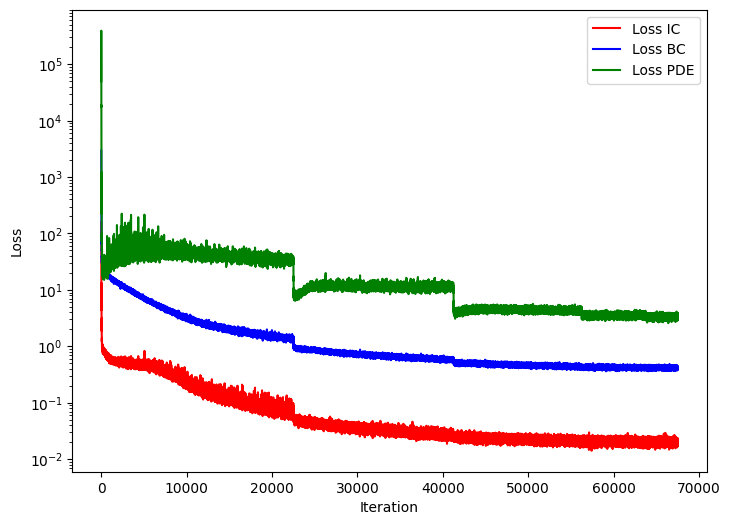

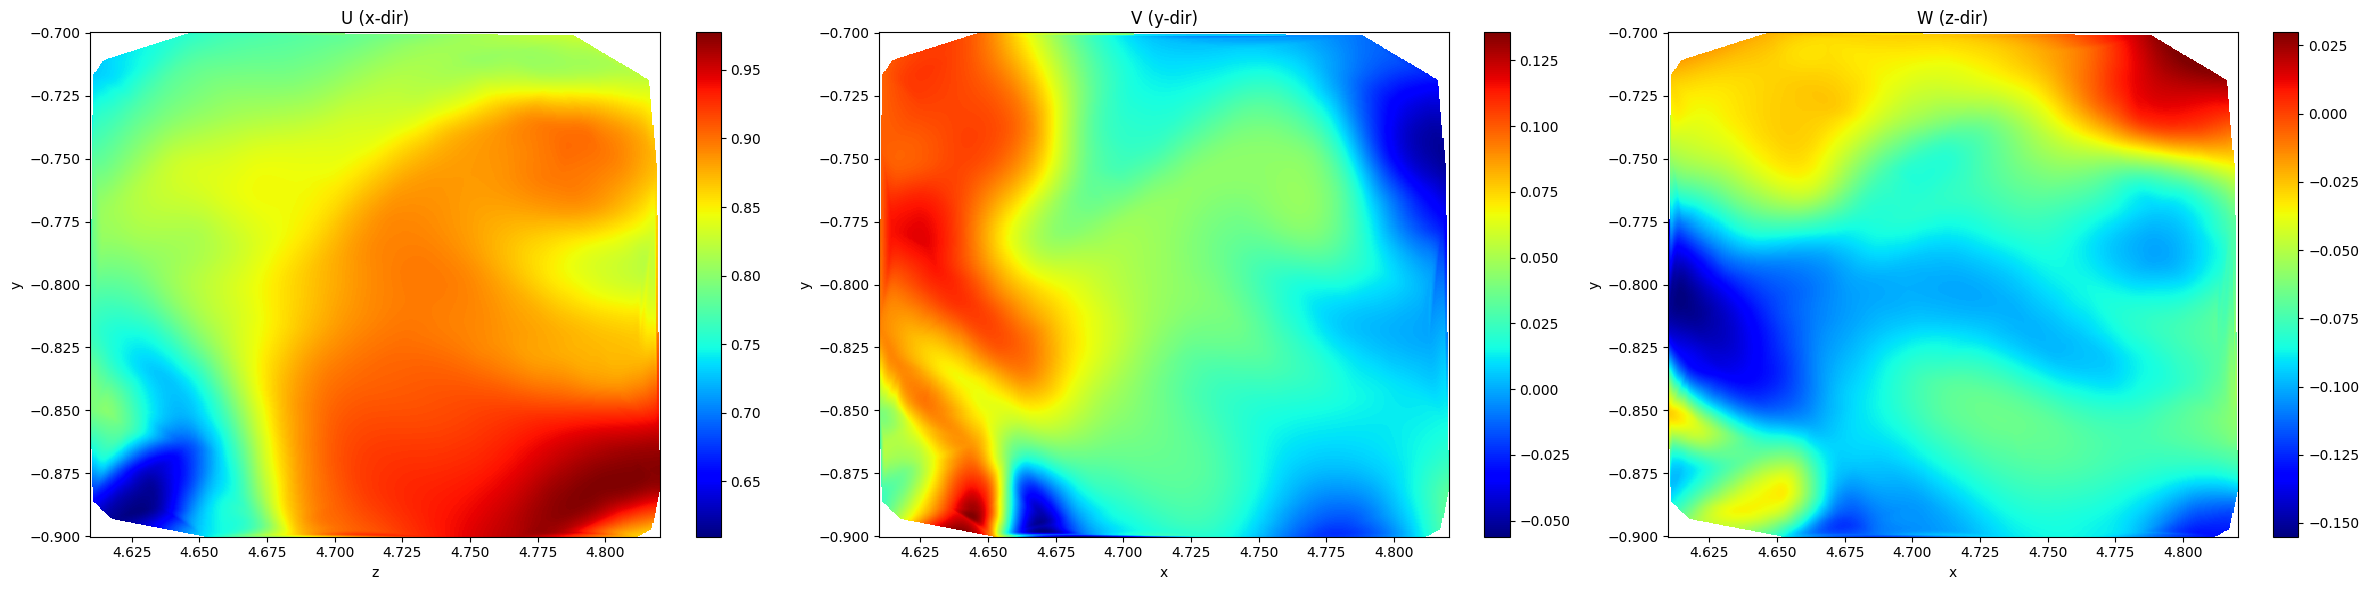

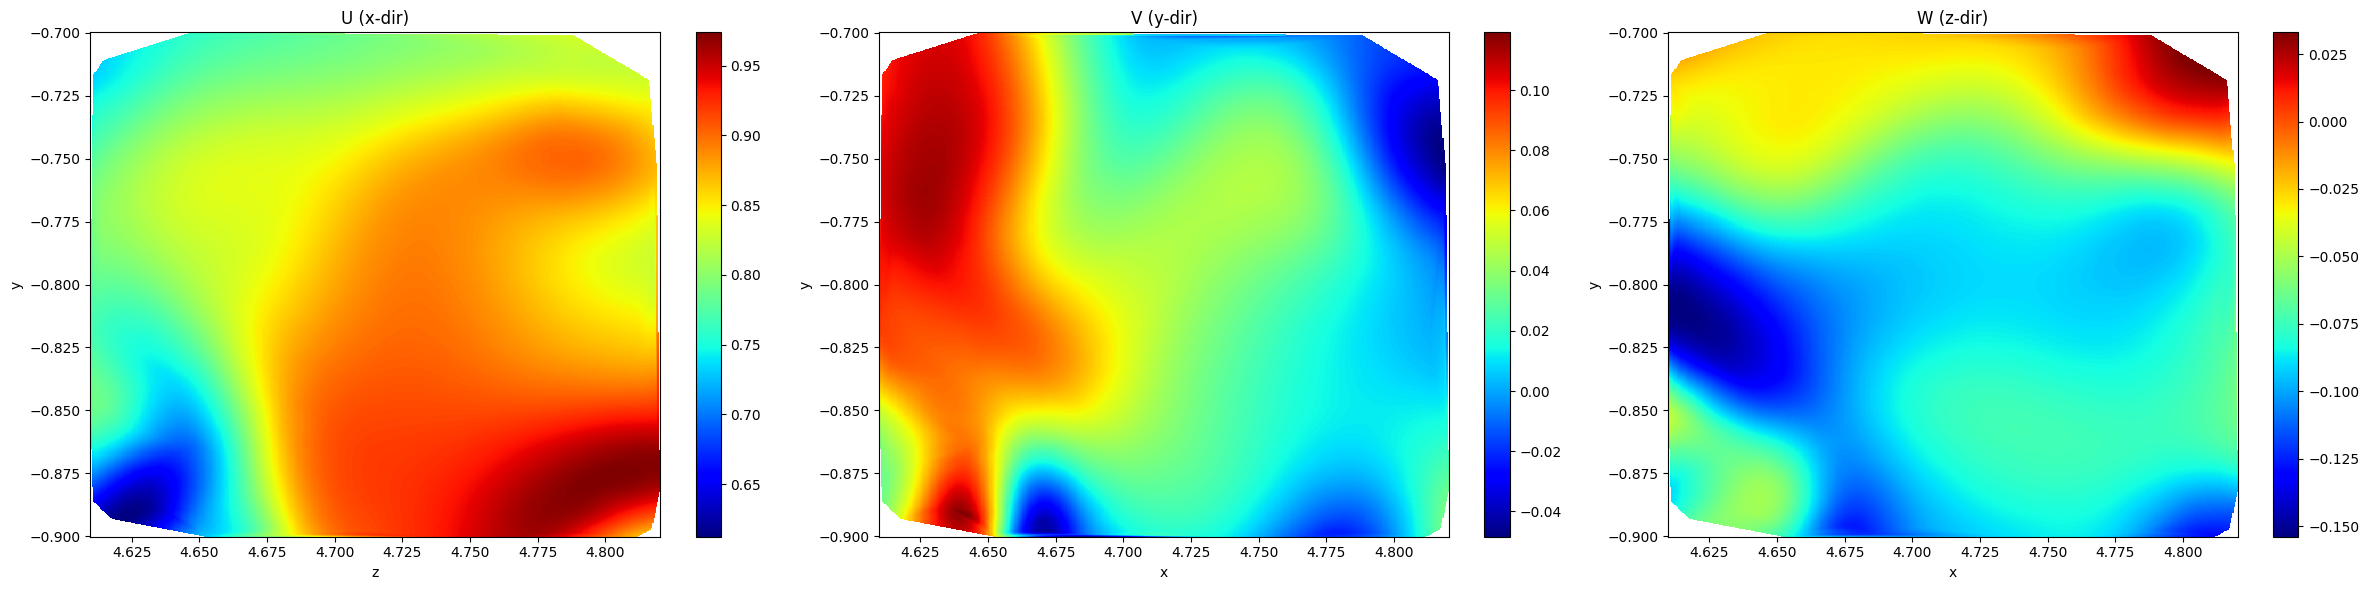

Error u: 6.130032e-03
Error v: 1.039540e-01
Error v: 7.187713e-02
5


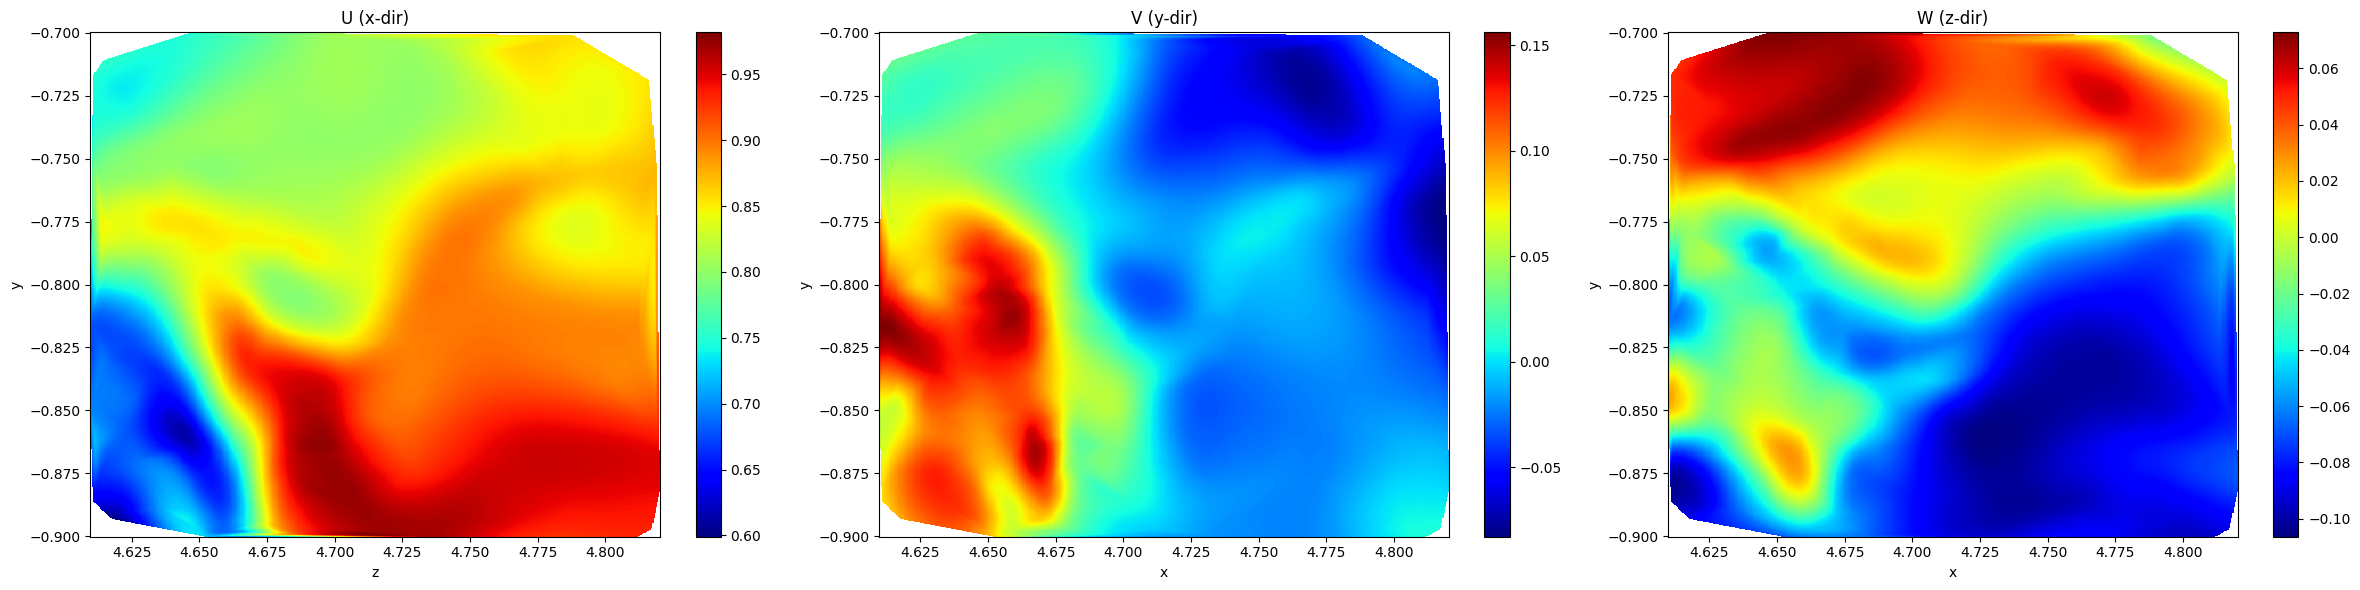

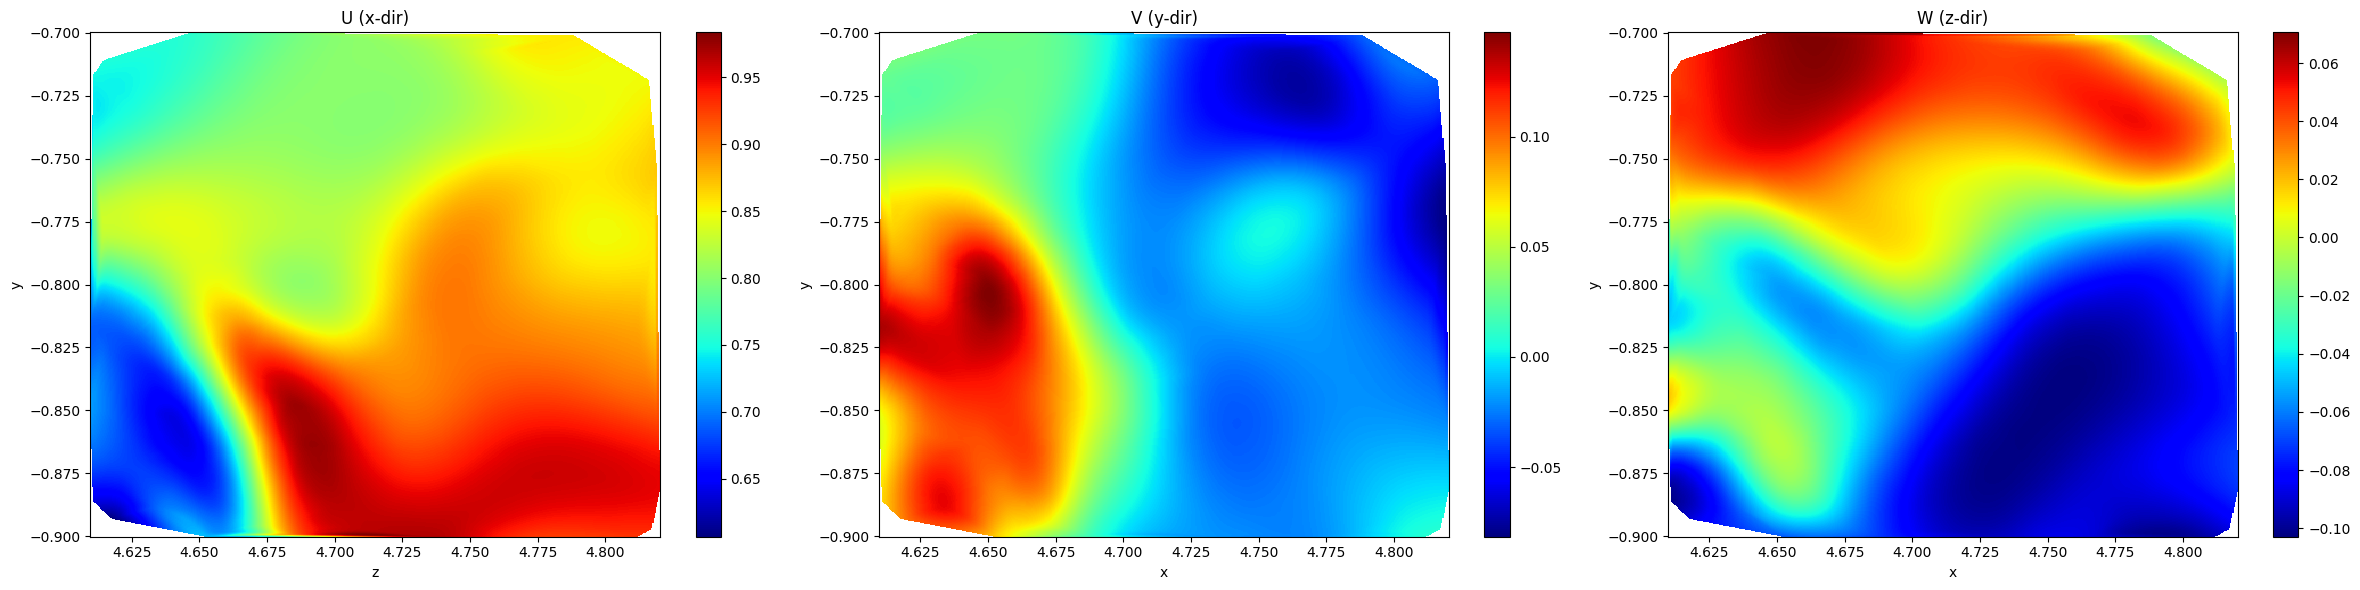

Error u: 9.624720e-03
Error v: 1.325574e-01
Error v: 1.247782e-01
6


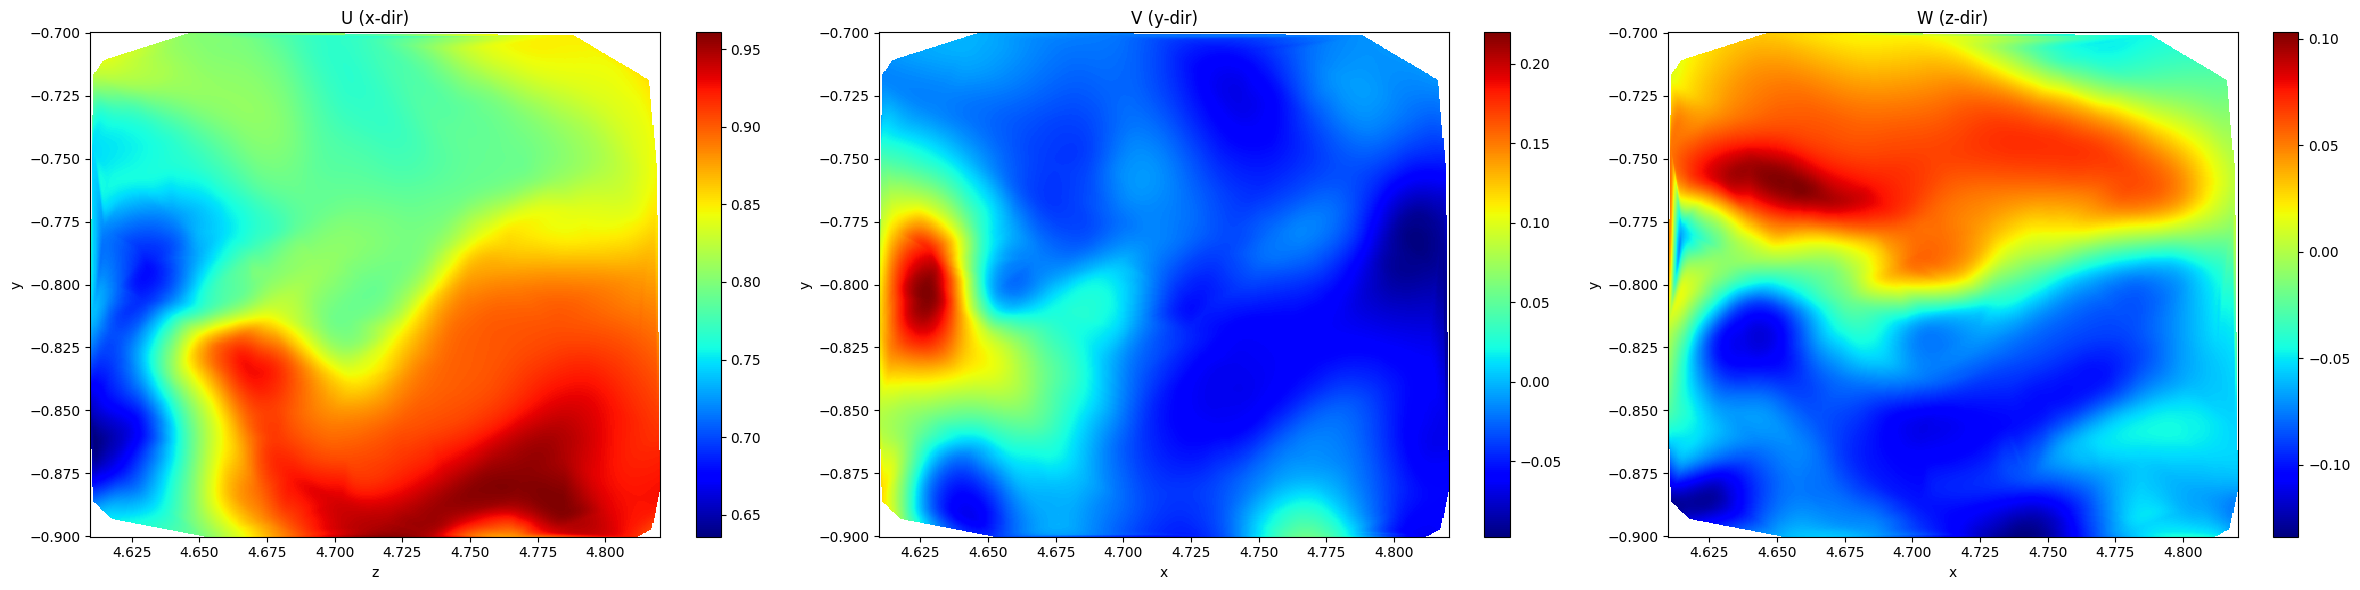

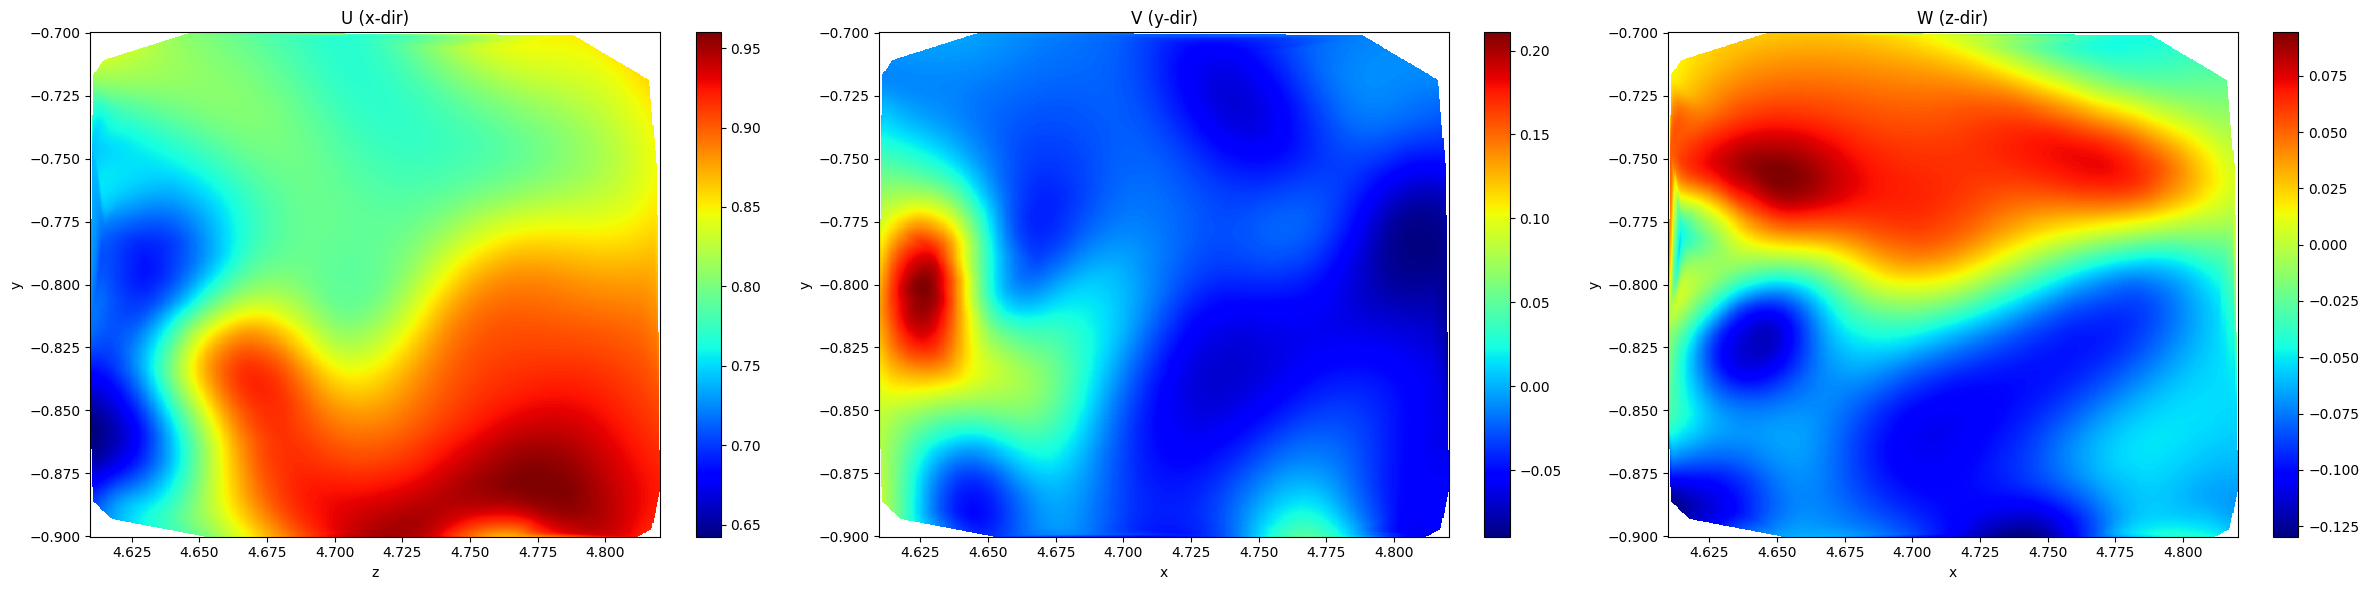

Error u: 7.409052e-03
Error v: 1.134440e-01
Error v: 9.384473e-02
7


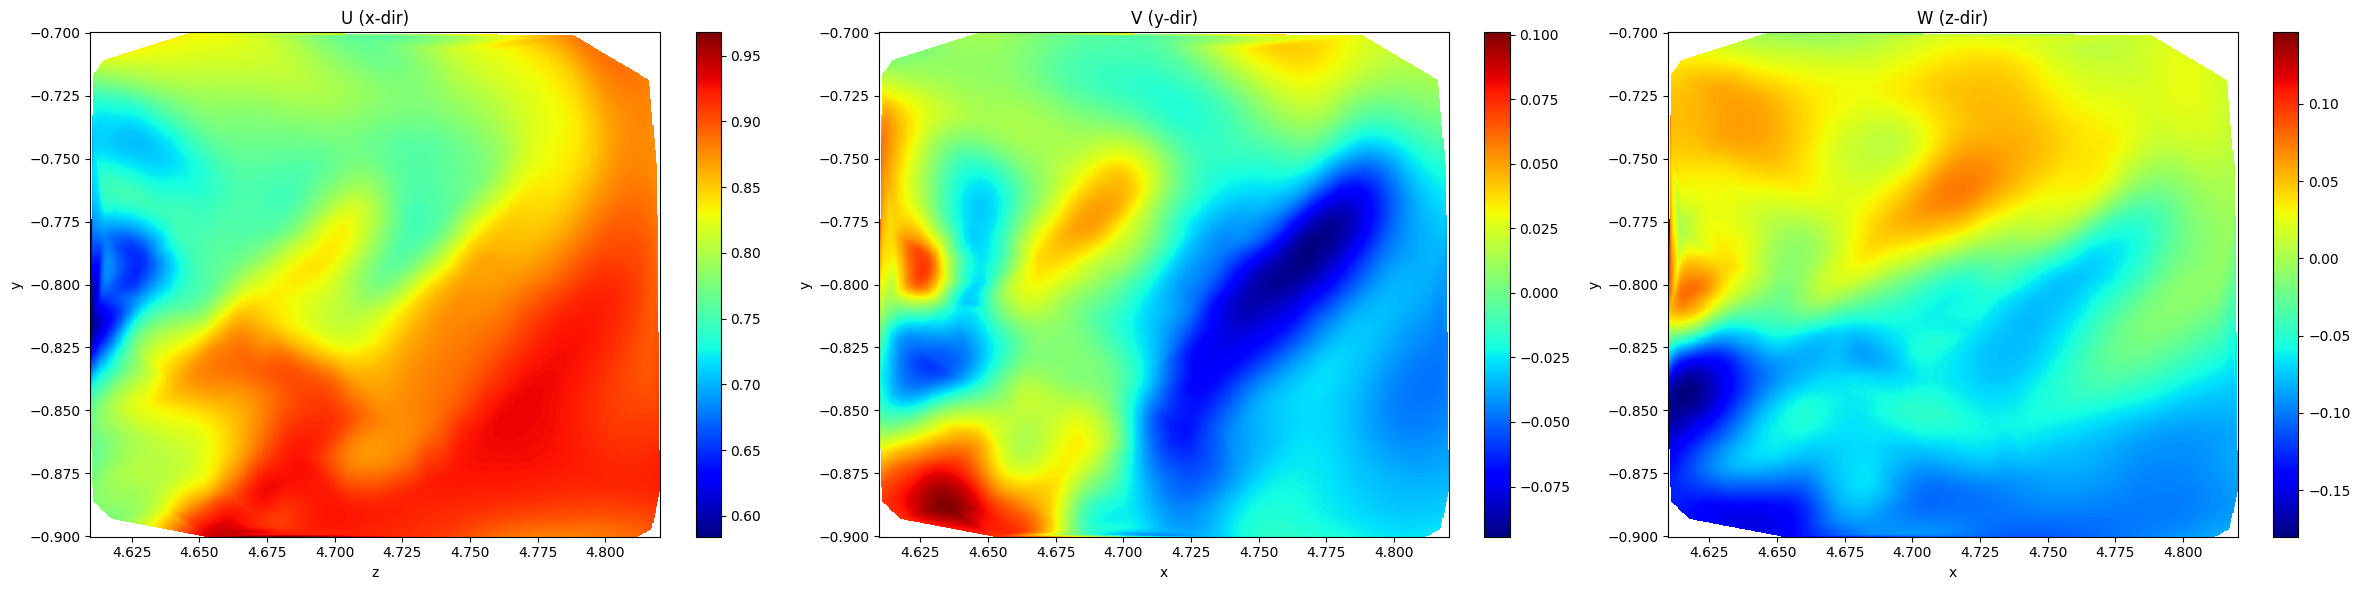

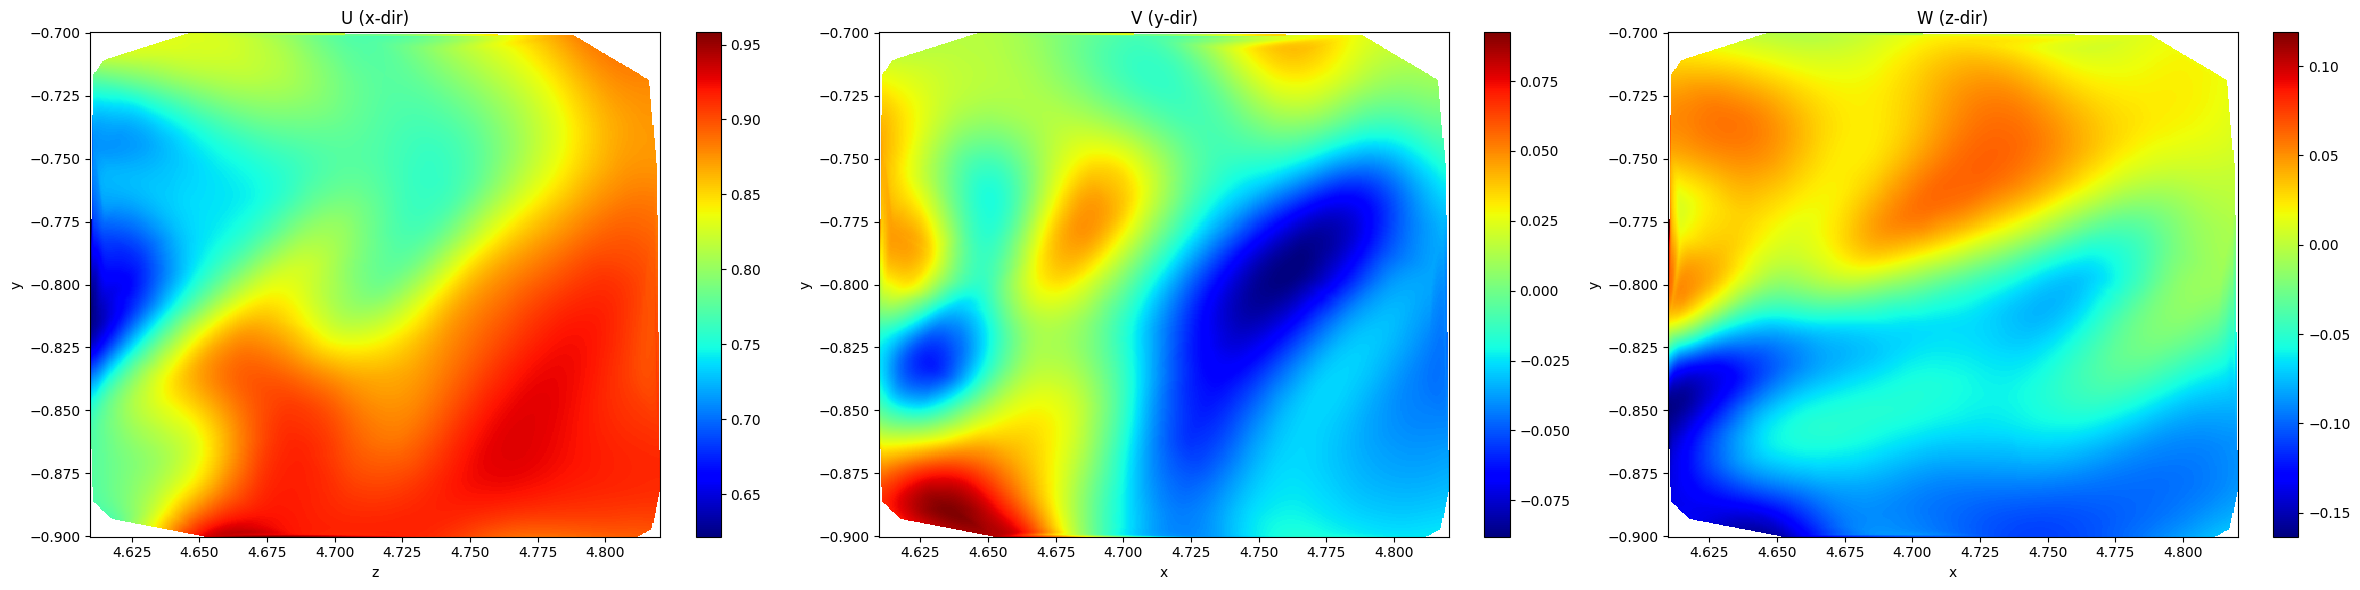

Error u: 1.136872e-02
Error v: 1.789367e-01
Error v: 1.244685e-01
8


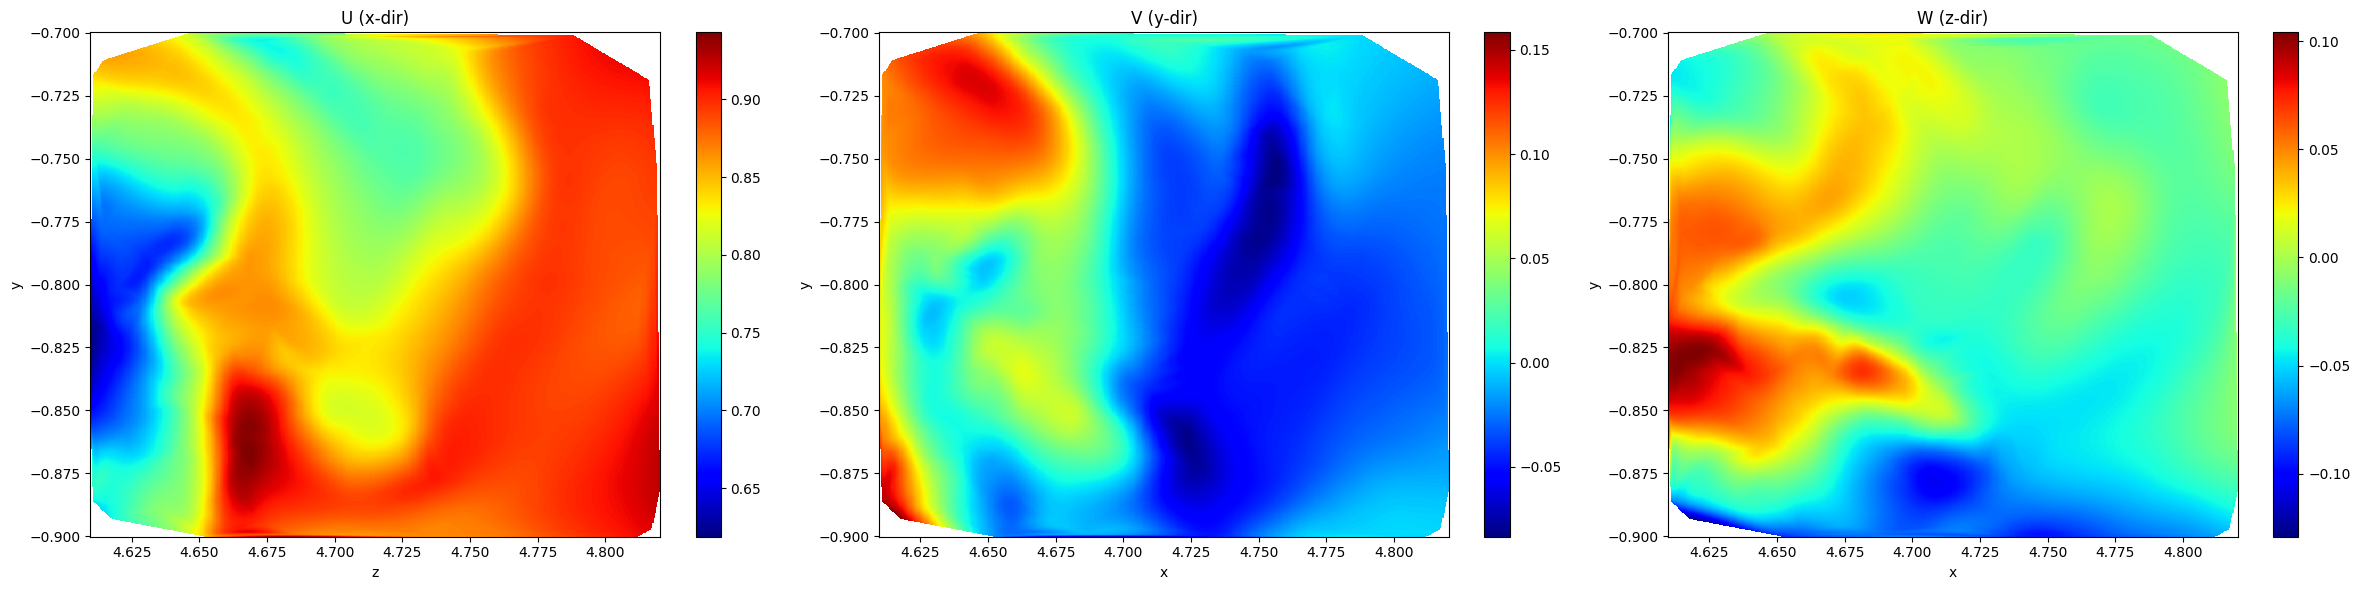

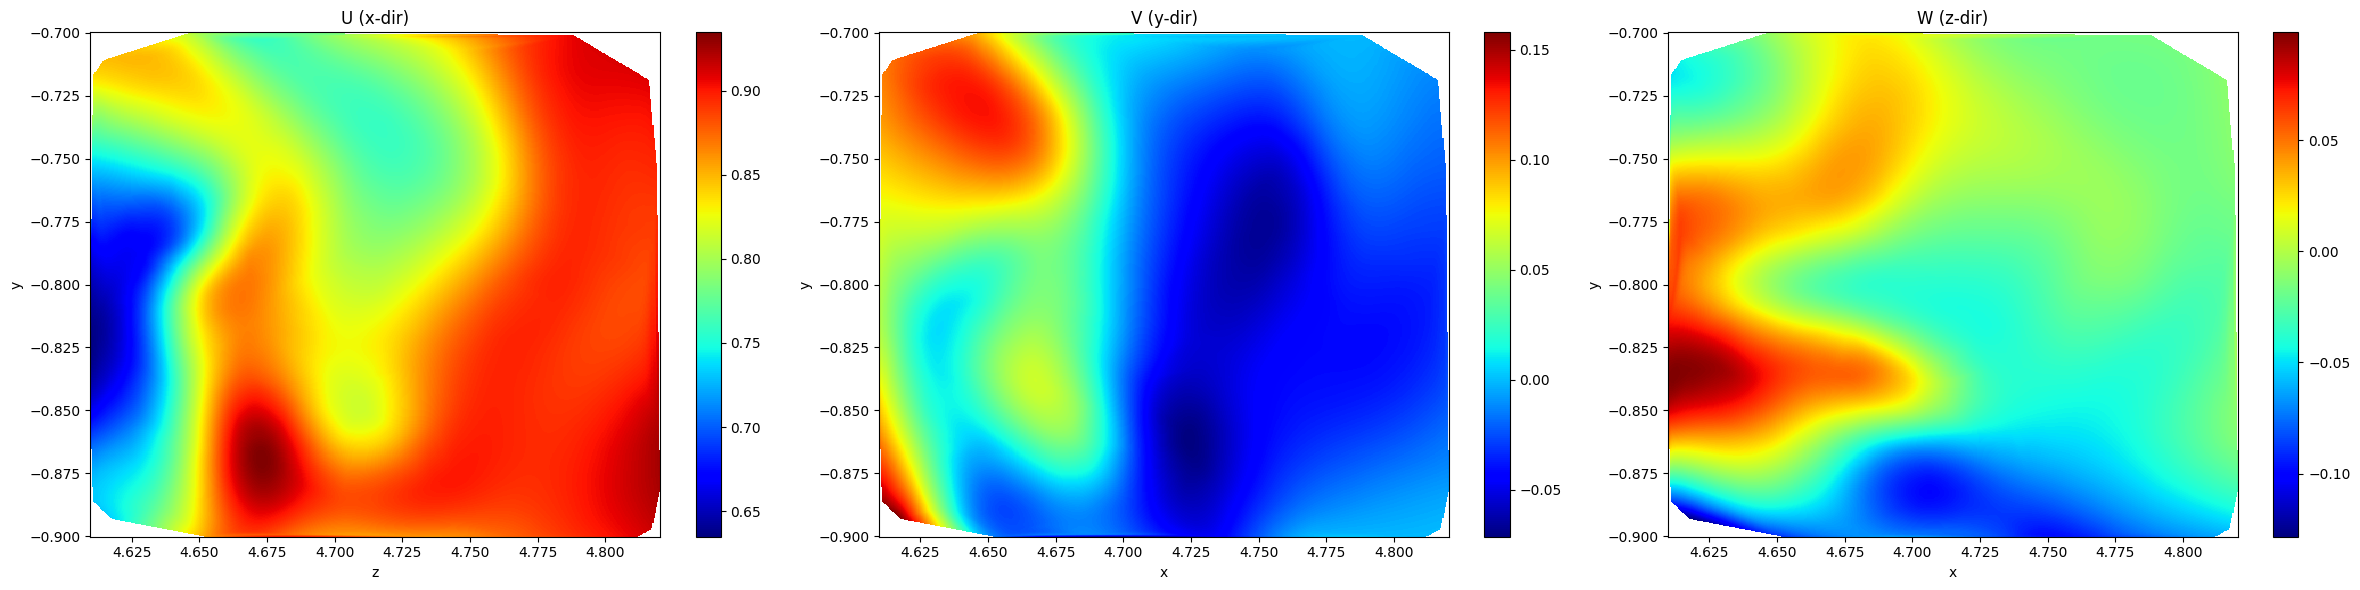

Error u: 9.669275e-03
Error v: 1.459263e-01
Error v: 1.811359e-01
9


In [ ]:
# @title Results

import pyJHTDB
import pyJHTDB.dbinfo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
######################################################################################################## loss decay
Bloss = np.concatenate((Bloss1, Bloss2, Bloss3, Bloss4, Bloss5), 0)
Bloss_i = np.concatenate((Bloss_i1, Bloss_i2, Bloss_i3, Bloss_i4, Bloss_i5), 0)
Bloss_b = np.concatenate((Bloss_b1, Bloss_b2, Bloss_b3, Bloss_b4, Bloss_b5), 0)
Bloss_pde = np.concatenate((Bloss_pde1, Bloss_pde2, Bloss_pde3, Bloss_pde4, Bloss_pde5), 0)

fig2 = plt.figure(figsize=(18,6))
ax = fig2.add_subplot(1,2,1)
ax.semilogy(range(len(Bloss_i)), Bloss_i,'k-', c = 'r', label = 'Loss IC')
ax.semilogy(range(len(Bloss_b)), Bloss_b,'k-', c = 'b', label = 'Loss BC')
ax.semilogy(range(len(Bloss_pde)), Bloss_pde,'k-', c = 'g', label = 'Loss PDE')
#ax.semilogy(range(len(loss)), loss,'k-', c = 'c', label = 'Loss')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss');
ax.legend(loc='upper right', frameon=True)
plt.savefig('DD-loss.png', bbox_inches='tight', dpi=600)
plt.show()
######################################################################################################## download reference data
def get_data(point_coords, time):
    """
    Get velocity and pressure at specified spatial points and a specified time in channel flow database.
    :param point_coords: Spatial coordinates of the data points of interest. Must be in single precision.
    :param time: Time of interest.
    :return: Velocity and velocity gradient arrays.
    """

    # Create library object
    lJHTDB = pyJHTDB.libJHTDB()

    # Initialize library object
    lJHTDB.initialize()

    # Get velocity
    u = lJHTDB.getData(time, point_coords,
                       sinterp='Lag4',
                       data_set='channel',
                       getFunction='getVelocity')

    # Get velocity gradient
    p = lJHTDB.getData(time, point_coords,
                            sinterp='Lag4',
                            data_set='channel',
                            getFunction='getPressure')

    # Finalize library object
    lJHTDB.finalize()

    return u, p

######################################################################################################## setting coordinates
xnode = np.linspace(12.66, 12.66, 1) #to plot at a z-y plane (x=12.66)
ynode = np.linspace(-0.9, -0.7, 201)
znode = np.linspace(4.61, 4.82, 211)


points = np.zeros((1, 201, 211, 3), np.float32) #to plot at a z-y plane (x=12.66)
points[:, :, :, 0] = xnode[:, None, None]
points[:, :, :, 1] = ynode[None, :, None]
points[:, :, :, 2] = znode[None, None, :]

points1 = points.reshape(-1,3)

idx_test = np.random.choice(points1.shape[0],500,replace = False)
test_l = points1[idx_test, :] # test points locations
######################################################################################################## results function
def results(spatio, temporal, test_snap):
  index = 0
  test_v , test_p = get_data(spatio, temporal)

  x_test = spatio[:,0]
  x_test = x_test.reshape(-1,1)
  y_test = spatio[:,1]
  y_test = y_test.reshape(-1,1)
  z_test = spatio[:,2]
  z_test = z_test.reshape(-1,1)

  u_star = test_v[:,0]
  u_star = u_star.reshape(-1,1)
  v_star = test_v[:,1]
  v_star = v_star.reshape(-1,1)
  w_star = test_v[:,2]
  w_star = w_star.reshape(-1,1)
  p_star = test_p

  X_s1 = np.concatenate((z_test, y_test), axis = 1)
  lbnd = X_s1.min(0)
  ubnd = X_s1.max(0)

  nn = 500 # grid size

  z = np.linspace(lbnd[0], ubnd[0], nn)
  y = np.linspace(lbnd[1], ubnd[1], nn)

  Z, Y = np.meshgrid(z, y)
  #X_star = np.concatenate((x_test, y_test, z_test), axis = 1)
  U_ref = griddata(X_s1, u_star.flatten(), (Z, Y), method = 'cubic')
  V_ref = griddata(X_s1, v_star.flatten(), (Z, Y), method = 'cubic')
  W_ref = griddata(X_s1, w_star.flatten(), (Z, Y), method = 'cubic')

  # Velocity conturs

  fig_3 = plt.figure(1, figsize=(24, 6))
  fig_3.add_subplot(1, 3, 1)
  plt.pcolor(Z, Y, U_ref, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('U (x-dir)')

  fig_3.add_subplot(1, 3, 2)
  plt.pcolor(Z, Y, V_ref, cmap='jet')
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('V (y-dir)')
  plt.tight_layout()

  fig_3.add_subplot(1, 3, 3)
  plt.pcolor(Z, Y, W_ref, cmap='jet')
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('W (z-dir)')
  plt.savefig(f'DD-Velocity-Ref{test_snap}.png', bbox_inches='tight', dpi=600)
  plt.show()

  # NN predicts
  for itm in range(len(Xb_list)):
    fourth_column = Xb_list[itm][:, 3]
    if temporal >= np.min(fourth_column) and temporal <= np.max(fourth_column):
      index = itm
      break
  weights = weights_list[index]
  biases = biases_list[index]
  #x_value_to_plot = xnode[0]
  z1 = z.reshape(-1,1)
  #y1 = y.reshape(-1,1)
  #x1 = np.full_like(z1, x_value_to_plot)
  t1 = np.full_like(z1, temporal)
  u_pred, v_pred, w_pred, p_pred = net_NS(x_test, y_test, z_test, t1, weights, biases)

  u_pred = u_pred.numpy()
  v_pred = v_pred.numpy()
  w_pred = w_pred.numpy()

  U_pred = griddata(X_s1, u_pred.flatten(), (Z, Y), method = 'cubic')
  V_pred = griddata(X_s1, v_pred.flatten(), (Z, Y), method = 'cubic')
  W_pred = griddata(X_s1, w_pred.flatten(), (Z, Y), method = 'cubic')


  fig_4 = plt.figure(1, figsize=(24, 6))
  fig_4.add_subplot(1, 3, 1)
  plt.pcolor(Z, Y, U_pred, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('U (x-dir)')


  fig_4.add_subplot(1, 3, 2)
  plt.pcolor(Z, Y, V_pred, cmap='jet')
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('V (y-dir)')
  plt.tight_layout()

  fig_4.add_subplot(1, 3, 3)
  plt.pcolor(Z, Y, W_pred, cmap='jet')
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('W (z-dir)')
  plt.savefig(f'DD-Velocity-Pred{test_snap}.png', bbox_inches='tight', dpi=600)
  plt.show()

  # # Error
  error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
  error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
  error_w = np.linalg.norm(w_star - w_pred, 2) / np.linalg.norm(w_star, 2)
  #error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

  print('Error u: %e' % (error_u))
  print('Error v: %e' % (error_v))
  print('Error v: %e' % (error_w))
  print(index)
  #print('Error p: %e' % (error_p))

  return

results(test_l, temporal = Test_snap6 * 0.0065, test_snap = Test_snap6)
results(test_l, temporal = Test_snap7 * 0.0065, test_snap = Test_snap7)
results(test_l, temporal = Test_snap8 * 0.0065, test_snap = Test_snap8)
results(test_l, temporal = Test_snap9 * 0.0065, test_snap = Test_snap9)
results(test_l, temporal = Test_snap10 * 0.0065, test_snap = Test_snap10)

## **DG-PINN**

In [ ]:
#@title Control Panel
# Network Architectures
layers = [4, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 4]
#time_steps1 = 9 # sub-domain 1
#time_steps2 = 18 # sub-domain 2: from sub-domain 1 up to the enetered value

ICT_threshold = 1.1
Total_time_steps = 20
NSD = 5 # number of subdomains
SD_TimeSteps = Total_time_steps/NSD
print('covered time = %d' % (Total_time_steps - (NSD - 1)))

covered time = 16


In [ ]:
#@title Data Structure

#x_range
xr1 = 12.25
xr2 = 12.75
#y_range
yr1 = -1.0
yr2 = -0.5
#z_range
zr1 = 4.5
zr2 = 5.0

x_NOP = (xr2 - xr1) / 0.001 + 1
y_NOP = (yr2 - yr1) / 0.001 + 1
z_NOP = (zr2 - zr1) / 0.001 + 1
# rounding up
x_NOP = int(np.ceil(x_NOP))
y_NOP = int(np.ceil(y_NOP))
z_NOP = int(np.ceil(z_NOP))

b_num = 26048 # number of BC points at each time frame

x0_train = train_ini1[:, 0:1]
y0_train = train_ini1[:, 1:2]
z0_train = train_ini1[:, 2:3]
t0_train = np.zeros(train_ini1[:, 0:1].shape, dtype= np.float32)
u0_train = train_iniv1[:, 0:1]
v0_train = train_iniv1[:, 1:2]
w0_train = train_iniv1[:, 2:3]

xnode = np.linspace(xr1, xr2, x_NOP)
ynode = np.linspace(yr1, yr2, y_NOP)
znode = np.linspace(zr1, zr2, z_NOP)

x_train_t = xnode.reshape(-1, 1)[np.random.choice(x_NOP, 80000, replace=True), :] # number of collocation points = second number in parantheses
y_train_t = ynode.reshape(-1, 1)[np.random.choice(y_NOP, 80000, replace=True), :]
z_train_t = znode.reshape(-1, 1)[np.random.choice(z_NOP, 80000, replace=True), :]
x_train = np.tile(x_train_t, ((int(SD_TimeSteps)), 1)).astype(np.float32)
y_train = np.tile(y_train_t, ((int(SD_TimeSteps)), 1)).astype(np.float32)
z_train = np.tile(z_train_t, ((int(SD_TimeSteps)), 1)).astype(np.float32)

n_t = (Total_time_steps / NSD) * (b_num) # to split boundary datasets
overlap = b_num  # Define the overlap size

X0_list = []
V0_list = []
Vb_list = []
Xb_list = []
X_list = []
t0_LSP_list = []

for i in range(NSD):
    # Convert i * n_t and (i+1) * n_t to integers
    start_index = int(i * (n_t - overlap))
    end_index = int(start_index + n_t)

    xb_train = train_xb1[start_index:end_index, 0:1]
    yb_train = train_xb1[start_index:end_index, 1:2]
    zb_train = train_xb1[start_index:end_index, 2:3]
    tb_train = train_xb1[start_index:end_index, 3:4]
    ub_train = train_vb1[start_index:end_index, 0:1]
    vb_train = train_vb1[start_index:end_index, 1:2]
    wb_train = train_vb1[start_index:end_index, 2:3]

    #t0_LSP = np.full_like(t0_train, tb_train[-1, 0])# to create a list (t0_LSP_list) of last time-snap of each subdomain.
    #the shape is like t0_train and the values are  tb_train[-1, 0]

    Bitch_size = (x0_train.shape[0] // nIter, 1) # to consent to the mini-batch size
    t0_LSP = np.full_like(x0_train[:Bitch_size[0]], tb_train[-1, 0])

    total_times = np.array(list(range(int(i * int(SD_TimeSteps)), int((i+1) * int(SD_TimeSteps))))) * 0.0065
    tt_train = total_times.repeat(80000)
    t_train = tt_train.reshape(-1, 1).astype(np.float32)

    #X0 = [x0_train, y0_train, z0_train, t0_train]
    #Xb = [xb_train, yb_train, zb_train, tb_train]
    #X = [x_train, y_train, z_train, t_train]

    X0 = np.concatenate([x0_train, y0_train, z0_train, t0_train], 1)
    V0 = np.concatenate([u0_train, v0_train, w0_train], 1)
    Xb = np.concatenate([xb_train, yb_train, zb_train, tb_train], 1)
    Vb = np.concatenate([ub_train, vb_train, wb_train], 1)
    X = np.concatenate([x_train, y_train, z_train, t_train], 1)

    X0_list.append(X0)
    V0_list.append(V0)
    Xb_list.append(Xb)
    Vb_list.append(Vb)
    X_list.append(X)
    t0_LSP_list.append(t0_LSP)

In [ ]:
#@title Neural Nets
lowb = Xb_list[0].min(0)  # minimal number in each column
upb = Xb_list[0].max(0)
#lowb = tf.cast(lowb, dtype=tf.float32)
#upb = tf.cast(upb, dtype=tf.float32)

def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
    return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                        dtype=tf.float32)

# do not need adaptation
def initialize_NN(layers):
    weights = []
    biases = []
    num_layers = len(layers)
    for l in range(0, num_layers - 1):
        W = xavier_init(size=[layers[l], layers[l + 1]])
        b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)
    return weights, biases

weights_list = []
biases_list = []
for i in range(NSD):
  weights, biases = initialize_NN(layers)
  weights_list.append(weights)
  biases_list.append(biases)

'''weights_dict = {}
biases_dict = {}

for i in range(NSD):
    # Generate variable names dynamically
    weights_var_name = f'weights{i}'
    biases_var_name = f'biases{i}'

    # Call initialize_NN(layers) to generate weights and biases
    weights, biases = initialize_NN(layers)

    # Use exec() to create variables with unique names
    exec(f"{weights_var_name} = weights")
    exec(f"{biases_var_name} = biases")'''

'''weights0, biases0 = initialize_NN(layers)
weights1, biases1 = initialize_NN(layers)
weights2, biases2 = initialize_NN(layers)
weights3, biases3 = initialize_NN(layers)'''

def forward_pass(X, weights, biases):
    num_layers = len(weights) + 1

    H = 2.0 * (tf.cast(X, dtype=tf.float32) - lowb) / (upb - lowb) - 1.0
    for l in range(0, num_layers - 2):
        W = weights[l]
        b = biases[l]
        H = tf.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

In [ ]:
#@title Computation Graph, Loss Function and Gradient

def net_f_NS(x, y, z, t, weights, biases):
    Re = 999.35
  # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as gg:
      gg.watch(t)
      gg.watch(x)
      gg.watch(y)
      gg.watch(z)
      with tf.GradientTape(persistent=True) as g:
          g.watch(t)
          g.watch(x)
          g.watch(y)
          g.watch(z)
          u_v_w_p = forward_pass(tf.concat([x, y, z, t], 1), weights, biases)
          u = u_v_w_p[:, 0:1]
          v = u_v_w_p[:, 1:2]
          w = u_v_w_p[:, 2:3]
          p = u_v_w_p[:, 3:4]
      u_t = tf.gradients(u, t)[0]
      u_x = tf.gradients(u, x)[0]
      u_y = tf.gradients(u, y)[0]
      u_z = tf.gradients(u, z)[0]

      v_t = tf.gradients(v, t)[0]
      v_x = tf.gradients(v, x)[0]
      v_y = tf.gradients(v, y)[0]
      v_z = tf.gradients(v, z)[0]

      w_t = tf.gradients(w, t)[0]
      w_x = tf.gradients(w, x)[0]
      w_y = tf.gradients(w, y)[0]
      w_z = tf.gradients(w, z)[0]

      p_x = tf.gradients(p, x)[0]
      p_y = tf.gradients(p, y)[0]
      p_z = tf.gradients(p, z)[0]

      del g
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    u_zz = tf.gradients(u_z, z)[0]

    v_xx = tf.gradients(v_x, x)[0]
    v_yy = tf.gradients(v_y, y)[0]
    v_zz = tf.gradients(v_z, z)[0]

    w_xx = tf.gradients(w_x, x)[0]
    w_yy = tf.gradients(w_y, y)[0]
    w_zz = tf.gradients(w_z, z)[0]
    del gg

    f_u = u_t + (u * u_x + v * u_y + w * u_z) + p_x - 1 / Re * (u_xx + u_yy + u_zz)
    f_v = v_t + (u * v_x + v * v_y + w * v_z) + p_y - 1 / Re * (v_xx + v_yy + v_zz)
    f_w = w_t + (u * w_x + v * w_y + w * w_z) + p_z - 1 / Re * (w_xx + w_yy + w_zz)
    f_e = u_x + v_y + w_z

    return u, v, w, p, f_u, f_v, f_w, f_e

# Forward pass
def net_NS(x, y, z, t, weights, biases):
  u_v_w_p = forward_pass(tf.concat([x, y, z, t], 1), weights, biases)
  u = u_v_w_p[:, 0:1]
  v = u_v_w_p[:, 1:2]
  w = u_v_w_p[:, 2:3]
  p = u_v_w_p[:, 3:4]

  return u, v, w, p

def compute_loss(Data, weights, biases, SD_index, ICT_cond):

  # Weighting factors
  alpha = 30 # IC
  beta = 30  # BC

  xei = Data[0]
  yei = Data[1]
  zei = Data[2]
  tei = Data[3]
  uei = Data[4]
  vei = Data[5]
  wei = Data[6]
  xeb = Data[7]
  yeb = Data[8]
  zeb = Data[9]
  teb = Data[10]
  ueb = Data[11]
  veb = Data[12]
  web = Data[13]
  xee = Data[14]
  yee = Data[15]
  zee = Data[16]
  tee = Data[17]
  #ICT_cond = tf.cast(ICT_cond, dtype=tf.float32)
  #ICT_cond = tf.norm(ICT_cond)
  #ICT_cond = tf.cast(ICT_cond, tf.float32)
  #ICT_cond = ICT_cond.numpy()
  if SD_index == 0:
    u_ini_pred, v_ini_pred, w_ini_pred, p_ini_pred = net_NS(xei, yei, zei, tei, weights, biases)
    u_boundary_pred, v_boundary_pred, w_boundary_pred, p_boundary_pred = net_NS(xeb, yeb, zeb, teb, weights, biases)
    _, _, _, _, f_u_pred, f_v_pred, f_w_pred, f_e_pred = net_f_NS(xee, yee, zee, tee, weights, biases)

    loss_i = tf.reduce_sum(tf.square(uei - u_ini_pred)) + \
                      tf.reduce_sum(tf.square(vei - v_ini_pred)) + \
                      tf.reduce_sum(tf.square(wei - w_ini_pred))
    loss_b = tf.reduce_sum(tf.square(ueb - u_boundary_pred)) + \
                      tf.reduce_sum(tf.square(veb - v_boundary_pred)) + \
                      tf.reduce_sum(tf.square(web - w_boundary_pred))
    loss_pde = tf.reduce_sum(tf.square(f_u_pred)) + \
                      tf.reduce_sum(tf.square(f_v_pred)) + \
                      tf.reduce_sum(tf.square(f_w_pred)) + \
                      tf.reduce_sum(tf.square(f_e_pred))

    loss = alpha * loss_i + beta * loss_b + loss_pde
    loss_i_threshhold = loss_i

  elif ICT_cond == 'on': # problem lies within here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    u_ini_pred, v_ini_pred, w_ini_pred, p_ini_pred = net_NS(xei, yei, zei, tei, weights, biases)
    u_boundary_pred, v_boundary_pred, w_boundary_pred, p_boundary_pred = net_NS(xeb, yeb, zeb, teb, weights, biases)
    _, _, _, _, f_u_pred, f_v_pred, f_w_pred, f_e_pred = net_f_NS(xee, yee, zee, tee, weights, biases)

    loss_i = tf.reduce_sum(tf.square(uei - u_ini_pred)) + \
                      tf.reduce_sum(tf.square(vei - v_ini_pred)) + \
                      tf.reduce_sum(tf.square(wei - w_ini_pred))
    loss_b = tf.reduce_sum(tf.square(ueb - u_boundary_pred)) + \
                      tf.reduce_sum(tf.square(veb - v_boundary_pred)) + \
                      tf.reduce_sum(tf.square(web - w_boundary_pred))
    loss_pde = tf.reduce_sum(tf.square(f_u_pred)) + \
                      tf.reduce_sum(tf.square(f_v_pred)) + \
                      tf.reduce_sum(tf.square(f_w_pred)) + \
                      tf.reduce_sum(tf.square(f_e_pred))

    loss = alpha * loss_i + beta * loss_b + loss_pde
    loss_i_threshhold = loss_i
  else:
    u_boundary_pred, v_boundary_pred, w_boundary_pred, p_boundary_pred = net_NS(xeb, yeb, zeb, teb, weights, biases)
    _, _, _, _, f_u_pred, f_v_pred, f_w_pred, f_e_pred = net_f_NS(xee, yee, zee, tee, weights, biases)

    loss_i = 0.0
    loss_b = tf.reduce_sum(tf.square(ueb - u_boundary_pred)) + \
                      tf.reduce_sum(tf.square(veb - v_boundary_pred)) + \
                      tf.reduce_sum(tf.square(web - w_boundary_pred))
    loss_pde = tf.reduce_sum(tf.square(f_u_pred)) + \
                      tf.reduce_sum(tf.square(f_v_pred)) + \
                      tf.reduce_sum(tf.square(f_w_pred)) + \
                      tf.reduce_sum(tf.square(f_e_pred))

    loss = loss_i + beta * loss_b + loss_pde
    loss_i_threshhold = ICT_threshold + 1

  tx = t0_LSP_list[SD_index] # the last time-snap of the subdomain
  u_1_pred, v_1_pred, w_1_pred, _ = net_NS(xei, yei, zei, tx, weights, biases)# Velocity at the last time-snap of the subdomain
  V0_pred = [u_1_pred, v_1_pred, w_1_pred]
  # to store spatial coordinates to feed the next subdomain in the next iteration
  x0_pred = xei
  y0_pred = yei
  z0_pred = zei
  X0_pred = [x0_pred, y0_pred, z0_pred]

  return loss, loss_i, loss_b, loss_pde, X0_pred, V0_pred, loss_i_threshhold

In [ ]:
#@title Run
from time import time
def get_grad(Data, weights, biases, SD_index, ICT_cond):
  with tf.GradientTape(persistent=True) as tape:
    # This tape is for derivatives with respect to trainable variables of NN (weights & biases)
    tape.watch([weights, biases])
    loss, loss_i, loss_b, loss_pde, X0_pred, V0_pred, loss_i_threshhold = compute_loss(Data, weights, biases, SD_index, ICT_cond)
  g = tape.gradient(loss, weights + biases)
  del tape
  return loss, g, loss_i, loss_b, loss_pde, X0_pred, V0_pred, loss_i_threshhold

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(Data_list, lr, index_list, ICT_list):
  # Compute current loss and gradient w.r.t. parameters
  #Do GD step
  #ICT_cond = [] # it's ok cuz in the 1st iteration, def compyte_loss is not dependent on the ICT_cond, but is dependent on the SD_index
  Closs = 0
  Closs_i = 0
  Closs_b = 0
  Closs_pde = 0
  up_w = []
  up_b = []
  V0_pred_list = []
  X0_pred_list = []
  loss_i_thr_list = []
  for Data, weightss, biasess, index, ICT_cond in zip(Data_list, weights_list, biases_list, index_list, ICT_list):
    loss, g, loss_i, loss_b, loss_pde, X0_pred, V0_pred, loss_i_threshhold = get_grad(Data, weightss, biasess, index, ICT_cond)
    optim.lr.assign(lr)  # Assign new learning rate
    optim.apply_gradients(zip(g, weightss + biasess))
    up_w.append(weightss)
    up_b.append(biasess)
    V0_pred_list.append(V0_pred)
    X0_pred_list.append(X0_pred)
    loss_i_thr_list.append(loss_i_threshhold)



    Closs += loss
    Closs_i += loss_i
    Closs_b += loss_b
    Closs_pde += loss_pde
  return Closs, Closs_i, Closs_b, Closs_pde, up_w, up_b, X0_pred_list, V0_pred_list, loss_i_thr_list

thr = tf.constant(ICT_threshold, dtype=tf.float32) #This threshold controls on what accuracy ICT is turned on
#thr = 0.3

def run(epoch, nIter, lr, ICT_cre, ICT_update, X0_pred_upd, V0_pred_upd):
  hist1 = []
  hist2 = []
  hist3 = []
  hist4 = []
  loss_list = []
  loss_i_list = []
  loss_b_list = []
  loss_pde_list = []


  ICT_Full_list = []

  if ICT_cre == 'yes':
    ICT_list = ['on'] + ['off'] * (NSD - 1)
    X0_pred_list = []
    V0_pred_list = []
  else:
    ICT_list = ICT_update
    X0_pred_list = X0_pred_upd
    V0_pred_list = V0_pred_upd

  for ep in range(epoch):

    batch_size1 = len(X0_list[0][:,0]) // nIter
    batch_size2 = len(Xb_list[0][:,0]) // nIter
    batch_size3 = len(X_list[0][:,0]) // nIter

    arr1 = np.arange(batch_size1 * nIter)
    arr2 = np.arange(batch_size2 * nIter)
    arr3 = np.arange(batch_size3 * nIter)

    permu1 = np.random.permutation(arr1).reshape((nIter, batch_size1))
    permu2 = np.random.permutation(arr2).reshape((nIter, batch_size2))
    permu3 = np.random.permutation(arr3).reshape((nIter, batch_size3))

    for it in range (nIter):
      Data_list = []
      index_list = []
      #ICT_list = []
      for i in range(NSD):
        SD_index = i
        x0 = (X0_list[i][:, 0]).reshape(-1,1)
        y0 = (X0_list[i][:, 1]).reshape(-1,1)
        z0 = (X0_list[i][:, 2]).reshape(-1,1)
        t0 = (X0_list[i][:, 3]).reshape(-1,1)
        u0 = (V0_list[i][:, 0]).reshape(-1,1)
        v0 = (V0_list[i][:, 1]).reshape(-1,1)
        w0 = (V0_list[i][:, 2]).reshape(-1,1)

        xb1 = (Xb_list[i][:, 0]).reshape(-1,1)
        yb1 = (Xb_list[i][:, 1]).reshape(-1,1)
        zb1 = (Xb_list[i][:, 2]).reshape(-1,1)
        tb1 = (Xb_list[i][:, 3]).reshape(-1,1)
        ub1 = (Vb_list[i][:, 0]).reshape(-1,1)
        vb1 = (Vb_list[i][:, 1]).reshape(-1,1)
        wb1 = (Vb_list[i][:, 2]).reshape(-1,1)

        x1 = (X_list[i][:, 0]).reshape(-1,1)
        y1 = (X_list[i][:, 1]).reshape(-1,1)
        z1 = (X_list[i][:, 2]).reshape(-1,1)
        t1 = (X_list[i][:, 3]).reshape(-1,1)

        x00 = x0[permu1[it, :], :]
        y00 = y0[permu1[it, :], :]
        z00 = z0[permu1[it, :], :]
        t00 = t0[permu1[it, :], :]
        u00 = u0[permu1[it, :], :]
        v00 = v0[permu1[it, :], :]
        w00 = w0[permu1[it, :], :]
        xb10 = xb1[permu2[it, :], :]
        yb10 = yb1[permu2[it, :], :]
        zb10 = zb1[permu2[it, :], :]
        tb10 = tb1[permu2[it, :], :]
        ub10 = ub1[permu2[it, :], :]
        vb10 = vb1[permu2[it, :], :]
        wb10 = wb1[permu2[it, :], :]
        x10 = x1[permu3[it, :], :]
        y10 = y1[permu3[it, :], :]
        z10 = z1[permu3[it, :], :]
        t10 = t1[permu3[it, :], :]

        if SD_index == 0 or not V0_pred_list:# the second condition is to Check if the list is empty
          Data = [x00, y00, z00, t00, u00, v00, w00, xb10, yb10,zb10, tb10, ub10, vb10, wb10, x10, y10, z10, t10]
        else:
          x00i = (X0_pred_list[i - 1][0])
          y00i = (X0_pred_list[i - 1][1])
          z00i = (X0_pred_list[i - 1][2])
          u00i = (V0_pred_list[i - 1][0])
          v00i = (V0_pred_list[i - 1][1])
          w00i = (V0_pred_list[i - 1][2])
          t00i = (t0_LSP_list[i - 1])
          Data = [x00i, y00i, z00i, t00i, u00i, v00i, w00i, xb10, yb10,zb10, tb10, ub10, vb10, wb10, x10, y10, z10, t10]

        Data_list.append(Data)
        index_list.append(SD_index)

      loss, loss_i, loss_b, loss_pde, up_w2, up_b2, X0_pred_list, V0_pred_list, loss_i_thr_list  = train_step(Data_list, lr, index_list, ICT_list)
      if it == 50 and ep%3 == 0:
        ICT_list = ['on']  # Initialize the list with the first item as 'on'
        for i in range(1, NSD):
            if loss_i_thr_list[i-1] < thr:
                ICT = 'on'
            else:
                ICT = 'off'
            ICT_list.append(ICT)
        #ICT_Full_list.append(ICT_list)
      #loss += loss
      #loss_i += loss_i
      #loss_b += loss_b
      #loss_pde += loss_pde
      loss_list.append(loss.numpy())
      loss_i_list.append(loss_i.numpy())
      loss_b_list.append(loss_b.numpy())
      loss_pde_list.append(loss_pde.numpy())

      if it%50 == 0:
        print('ep {:03d}, It {:05d}, loss = {:10.3e}, loss_i = {:10.3e}, loss_b = {:10.3e}, loss_pde= {:10.3e}, ICT = [{}, {}, {}, {}, {}]' \
              .format(ep, it, loss, loss_i, loss_b, loss_pde, *ICT_list))
      if ep == epoch-1 and it == nIter -1:
        updated_w = up_w2
        updated_b = up_b2
  return loss_list, loss_i_list, loss_b_list, loss_pde_list, ICT_list, X0_pred_list, V0_pred_list
#start timer
# Create the optimizer with a placeholder learning rate
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0)

time0 = time()
Closs1, Closs_i1, Closs_b1, Closs_pde1, ICT_list, X0_pred_list, V0_pred_list = run(Epo1, nIter, 1e-3, 'yes', None, None, None)
Closs2, Closs_i2, Closs_b2, Closs_pde2, ICT_list, X0_pred_list, V0_pred_list = run(Epo2, nIter, 2e-4, 'no', ICT_list, X0_pred_list, V0_pred_list)
Closs3, Closs_i3, Closs_b3, Closs_pde3, ICT_list, X0_pred_list, V0_pred_list = run(Epo3, nIter, 4e-5, 'no', ICT_list, X0_pred_list, V0_pred_list)
Closs4, Closs_i4, Closs_b4, Closs_pde4, ICT_list, X0_pred_list, V0_pred_list = run(Epo4, nIter, 9e-6, 'no', ICT_list, X0_pred_list, V0_pred_list)
Closs5, Closs_i5, Closs_b5, Closs_pde5, ICT_list, X0_pred_list, V0_pred_list = run(Epo5, nIter, 9e-7, 'no', ICT_list, X0_pred_list, V0_pred_list)
# Print computation time
print('\nComputation time: {} seconds' .format(time()-time0))

ep 000, It 00000, loss =  1.364e+06, loss_i =  7.627e+02, loss_b =  2.764e+03, loss_pde=  1.258e+06, ICT = [on, off, off, off, off]
ep 000, It 00050, loss =  1.685e+04, loss_i =  5.877e+01, loss_b =  4.021e+02, loss_pde=  3.023e+03, ICT = [on, off, off, off, off]
ep 000, It 00100, loss =  1.120e+04, loss_i =  2.597e+01, loss_b =  3.285e+02, loss_pde=  5.641e+02, ICT = [on, off, off, off, off]
ep 001, It 00000, loss =  9.448e+03, loss_i =  2.501e+01, loss_b =  2.742e+02, loss_pde=  4.703e+02, ICT = [on, off, off, off, off]
ep 001, It 00050, loss =  1.063e+04, loss_i =  2.338e+01, loss_b =  3.178e+02, loss_pde=  3.971e+02, ICT = [on, off, off, off, off]
ep 001, It 00100, loss =  8.656e+03, loss_i =  2.300e+01, loss_b =  2.471e+02, loss_pde=  5.523e+02, ICT = [on, off, off, off, off]
ep 002, It 00000, loss =  5.910e+03, loss_i =  2.061e+01, loss_b =  1.638e+02, loss_pde=  3.762e+02, ICT = [on, off, off, off, off]
ep 002, It 00050, loss =  6.840e+03, loss_i =  2.062e+01, loss_b =  1.971e+0

In [ ]:
# @title Results
import pyJHTDB
import pyJHTDB.dbinfo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
######################################################################################################## loss decay
Closs = np.concatenate((Closs1, Closs2, Closs3, Closs4, Closs5), 0)
Closs_i = np.concatenate((Closs_i1, Closs_i2, Closs_i3, Closs_i4, Closs_i5), 0)
Closs_b = np.concatenate((Closs_b1, Closs_b2, Closs_b3, Closs_b4, Closs_b5), 0)
Closs_pde = np.concatenate((Closs_pde1, Closs_pde2, Closs_pde3, Closs_pde4, Closs_pde5), 0)

fig2 = plt.figure(figsize=(18,6))
ax = fig2.add_subplot(1,2,1)
ax.semilogy(range(len(Closs_i)), Closs_i,'k-', c = 'r', label = 'Loss IC')
ax.semilogy(range(len(Closs_b)), Closs_b,'k-', c = 'b', label = 'Loss BC')
ax.semilogy(range(len(Closs_pde)), Closs_pde,'k-', c = 'g', label = 'Loss PDE')
#ax.semilogy(range(len(loss)), loss,'k-', c = 'c', label = 'Loss')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss');
ax.legend(loc='upper right', frameon=True)
plt.savefig('TD-loss.png', bbox_inches='tight', dpi=500)
plt.show()
######################################################################################################## download reference data
def get_data(point_coords, time):
    """
    Get velocity and pressure at specified spatial points and a specified time in channel flow database.
    :param point_coords: Spatial coordinates of the data points of interest. Must be in single precision.
    :param time: Time of interest.
    :return: Velocity and velocity gradient arrays.
    """

    # Create library object
    lJHTDB = pyJHTDB.libJHTDB()

    # Initialize library object
    lJHTDB.initialize()

    # Get velocity
    u = lJHTDB.getData(time, point_coords,
                       sinterp='Lag4',
                       data_set='channel',
                       getFunction='getVelocity')

    # Get velocity gradient
    p = lJHTDB.getData(time, point_coords,
                            sinterp='Lag4',
                            data_set='channel',
                            getFunction='getPressure')

    # Finalize library object
    lJHTDB.finalize()

    return u, p

######################################################################################################## setting coordinates
xnode = np.linspace(xr1, xr1, 1) #to plot at a z-y plane (x=12.66)
ynode = np.linspace(yr1, yr2, y_NOP)
znode = np.linspace(zr1, zr2, z_NOP)


points = np.zeros((1, y_NOP, z_NOP, 3), np.float32) #to plot at a z-y plane (x=12.66)
points[:, :, :, 0] = xnode[:, None, None]
points[:, :, :, 1] = ynode[None, :, None]
points[:, :, :, 2] = znode[None, None, :]

points1 = points.reshape(-1,3)

idx_test = np.random.choice(points1.shape[0],500,replace = False)
test_l = points1[idx_test, :] # test points locations
######################################################################################################## results function
def results(spatio, temporal, test_snap):
  index = 0
  test_v , test_p = get_data(spatio, temporal)

  x_test = spatio[:,0]
  x_test = x_test.reshape(-1,1)
  y_test = spatio[:,1]
  y_test = y_test.reshape(-1,1)
  z_test = spatio[:,2]
  z_test = z_test.reshape(-1,1)

  u_star = test_v[:,0]
  u_star = u_star.reshape(-1,1)
  v_star = test_v[:,1]
  v_star = v_star.reshape(-1,1)
  w_star = test_v[:,2]
  w_star = w_star.reshape(-1,1)
  p_star = test_p

  X_s1 = np.concatenate((z_test, y_test), axis = 1)
  lbnd = X_s1.min(0)
  ubnd = X_s1.max(0)

  nn = 500 # grid size

  z = np.linspace(lbnd[0], ubnd[0], nn)
  y = np.linspace(lbnd[1], ubnd[1], nn)

  Z, Y = np.meshgrid(z, y)
  #X_star = np.concatenate((x_test, y_test, z_test), axis = 1)
  U_ref = griddata(X_s1, u_star.flatten(), (Z, Y), method = 'cubic')
  V_ref = griddata(X_s1, v_star.flatten(), (Z, Y), method = 'cubic')
  W_ref = griddata(X_s1, w_star.flatten(), (Z, Y), method = 'cubic')

  # Velocity conturs

  fig_3 = plt.figure(1, figsize=(24, 6))
  fig_3.add_subplot(1, 3, 1)
  plt.pcolor(Z, Y, U_ref, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('U')

  fig_3.add_subplot(1, 3, 2)
  plt.pcolor(Z, Y, V_ref, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('V')
  plt.tight_layout()

  fig_3.add_subplot(1, 3, 3)
  plt.pcolor(Z, Y, W_ref, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('W')
  plt.savefig(f'DDICT-Velocity-Ref{test_snap}.png', bbox_inches='tight', dpi=500)
  plt.show()

  # NN predicts
  for itm in range(len(Xb_list)):
    fourth_column = Xb_list[itm][:, 3]
    if temporal >= np.min(fourth_column) and temporal <= np.max(fourth_column):
      index = itm
      break
  weights = weights_list[index]
  biases = biases_list[index]
  #x_value_to_plot = xnode[0]
  z1 = z.reshape(-1,1)
  #y1 = y.reshape(-1,1)
  #x1 = np.full_like(z1, x_value_to_plot)
  t1 = np.full_like(z1, temporal)
  u_pred, v_pred, w_pred, p_pred = net_NS(x_test, y_test, z_test, t1, weights, biases)

  u_pred = u_pred.numpy()
  v_pred = v_pred.numpy()
  w_pred = w_pred.numpy()

  U_pred = griddata(X_s1, u_pred.flatten(), (Z, Y), method = 'cubic')
  V_pred = griddata(X_s1, v_pred.flatten(), (Z, Y), method = 'cubic')
  W_pred = griddata(X_s1, w_pred.flatten(), (Z, Y), method = 'cubic')


  fig_4 = plt.figure(1, figsize=(24, 6))
  fig_4.add_subplot(1, 3, 1)
  plt.pcolor(Z, Y, U_pred, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('U')


  fig_4.add_subplot(1, 3, 2)
  plt.pcolor(Z, Y, V_pred, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('V')
  plt.tight_layout()

  fig_4.add_subplot(1, 3, 3)
  plt.pcolor(Z, Y, W_pred, cmap='jet')
  plt.colorbar()
  plt.xlabel('z')
  plt.ylabel('y')
  plt.title('W')
  plt.savefig(f'DDICT-Velocity-Pred{test_snap}.png', bbox_inches='tight', dpi=500)
  plt.show()

  # # Error
  error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
  error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
  error_w = np.linalg.norm(w_star - w_pred, 2) / np.linalg.norm(w_star, 2)
  #error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

  print('Error u: %e' % (error_u))
  print('Error v: %e' % (error_v))
  print('Error w: %e' % (error_w))
  print(index)
  #print('Error p: %e' % (error_p))

  return

results(test_l, temporal = Test_snap1 * 0.0065, test_snap = Test_snap1)
results(test_l, temporal = Test_snap2 * 0.0065, test_snap = Test_snap2)
results(test_l, temporal = Test_snap3 * 0.0065, test_snap = Test_snap3)
results(test_l, temporal = Test_snap4 * 0.0065, test_snap = Test_snap4)
#results(test_l, temporal = Test_snap5 * 0.0065, test_snap = Test_snap5)